<a href="https://colab.research.google.com/github/rohankalbag/ee782-iitb/blob/main/EE782_A1_20d170033.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EE 782 Assignment 1 - LSTM for Stock Market Prediction

## Name : Rohan Rajesh Kalbag
## Roll: 20D170033

### Using Kaggle API for frequent and fast download of Dataset, unable to use mounting GDrive after restrictions added by CC on Google Services

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!wget https://rohankalbag.github.io/kaggle.json
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d rohanrkalbag/ee782

mkdir: cannot create directory ‘/root/.kaggle’: File exists
--2023-09-16 19:08:27--  https://rohankalbag.github.io/kaggle.json
Resolving rohankalbag.github.io (rohankalbag.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rohankalbag.github.io (rohankalbag.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68 [application/json]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      68  --.-KB/s    in 0s      

2023-09-16 19:08:27 (5.05 MB/s) - ‘kaggle.json’ saved [68/68]

ref                                                        title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                    Mo

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import torch

### Chosen Stocks

In [3]:
chosen_stocks = ['AMD', 'ADBE', 'AAPL', 'AMZN']

import zipfile

zip_file_path = './ee782.zip'

output_directory = './'

# Open the .zip file and extract selected files
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_name in chosen_stocks:
        try:
            zip_ref.extract('sp500_tickers_A-D_1min_1pppix/%s_1min.txt' % file_name, output_directory)
            print(f'Extracted {file_name} to {output_directory}')
        except KeyError:
            print(f'File {file_name} not found in the archive.')

print('Unzip process completed.')

Extracted AMD to ./
Extracted ADBE to ./
Extracted AAPL to ./
Extracted AMZN to ./
Unzip process completed.


## 1a) Minute by Minute Closing Price for a Few Stocks

In [4]:
def get_subset_of_dataset(stockname, start_date, end_date):
    # function which returns a subset of data, given start and end date, and stock name
    filename = 'sp500_tickers_A-D_1min_1pppix/%s_1min.txt' % stockname
    df = pd.read_csv(filename, header=0, names=["datetime", "open", "high", "low", "close", "volume"])
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    df = df[(df['datetime'] < end_date) & (df['datetime'] >= start_date)]
    return df

def visualize_stock_prices_min(df, title):
    fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharex=True)
    column_names=['open', 'close', 'high', 'low']

    for i, col_name in enumerate(column_names):
      axes[0].plot(df['datetime'], df[col_name], '-s', label=col_name)

    axes[0].set_title("Stock Prices")
    dtFmt = mdates.DateFormatter('%Y-%m-%d %H:%M')
    axes[0].xaxis.set_major_formatter(dtFmt)
    axes[0].xaxis.set_tick_params(rotation=90, labelsize='x-small')
    axes[0].legend(loc='upper left')

    axes[1].plot(df['datetime'], df['volume'], '-s', label='volume')
    axes[1].set_title("Volume of Stock Traded")
    dtFmt = mdates.DateFormatter('%Y-%m-%d %H:%M')
    axes[1].xaxis.set_major_formatter(dtFmt)
    axes[1].xaxis.set_tick_params(rotation=90, labelsize='x-small')
    axes[1].legend(loc='upper left')

    plt.xlabel("timestamp")
    plt.suptitle(title, fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust subplot layout
    plt.show()

### Let us print for the case of January 3rd 2020 from 12:00 pm to 3:00 pm for each of the stocks

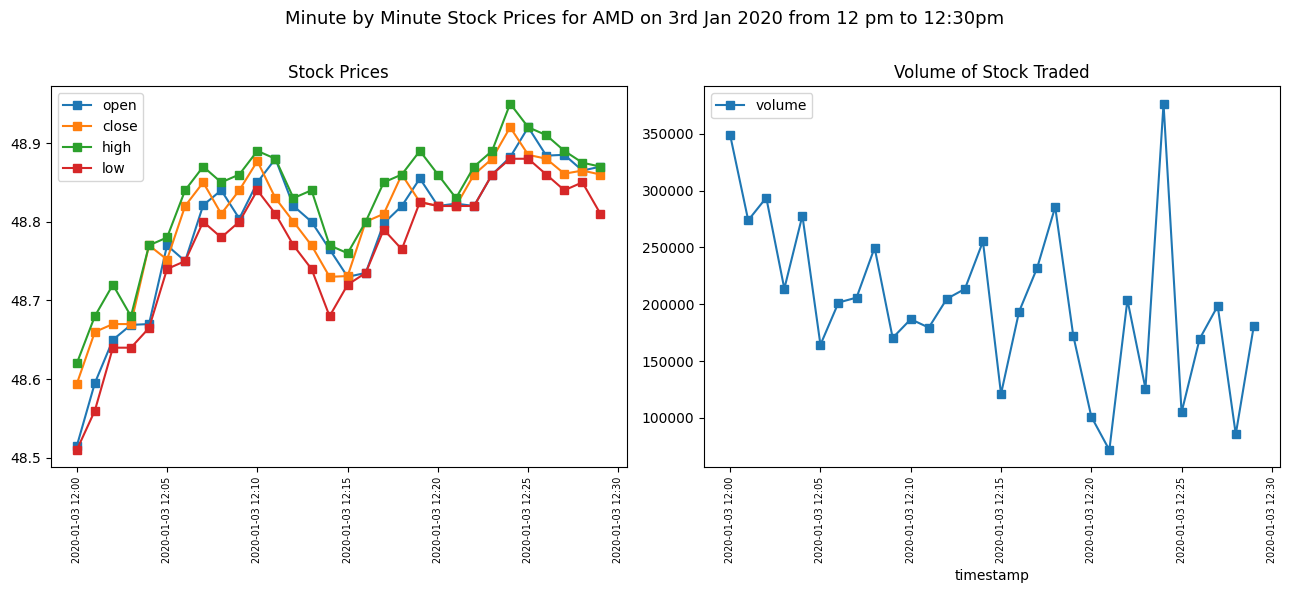

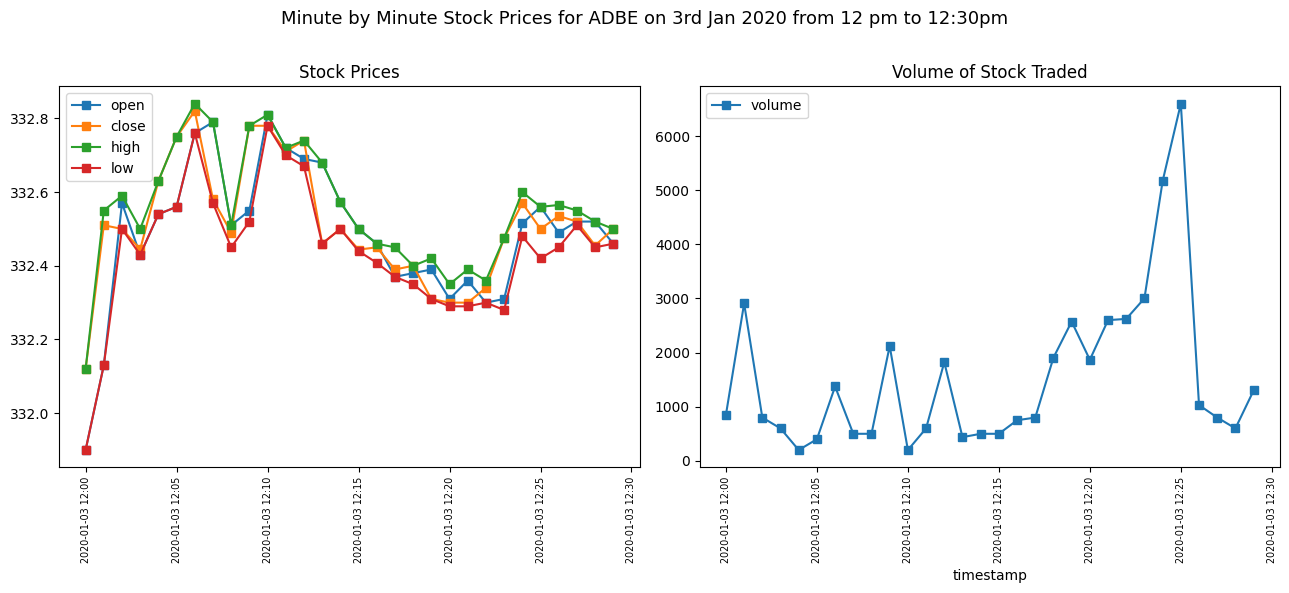

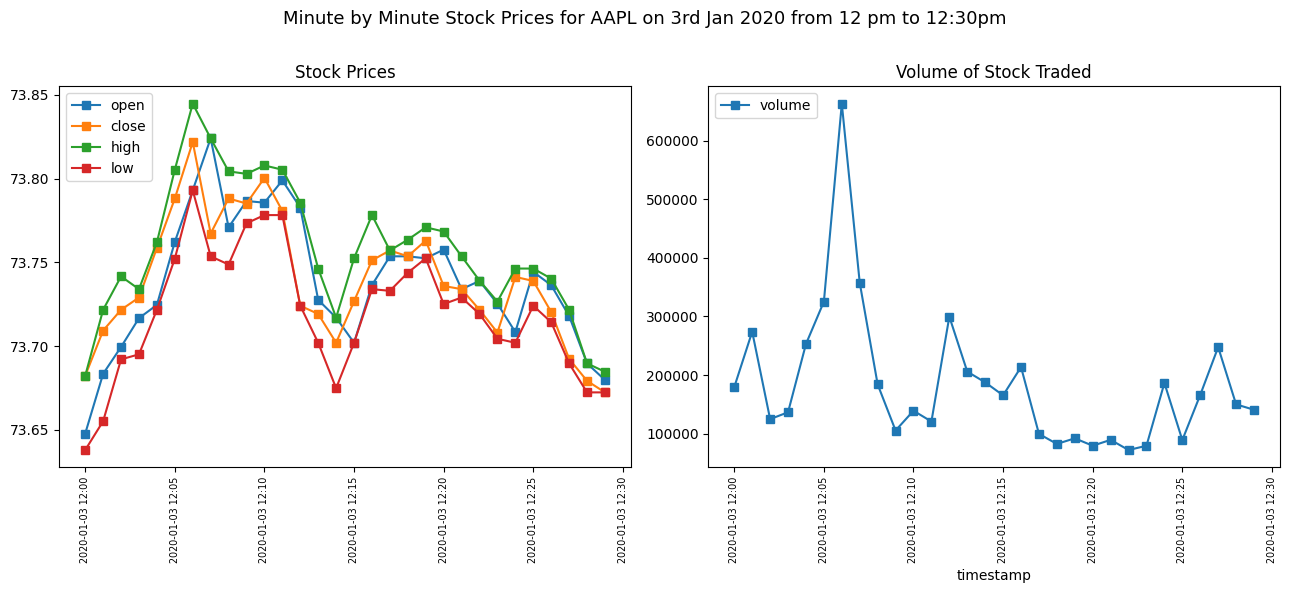

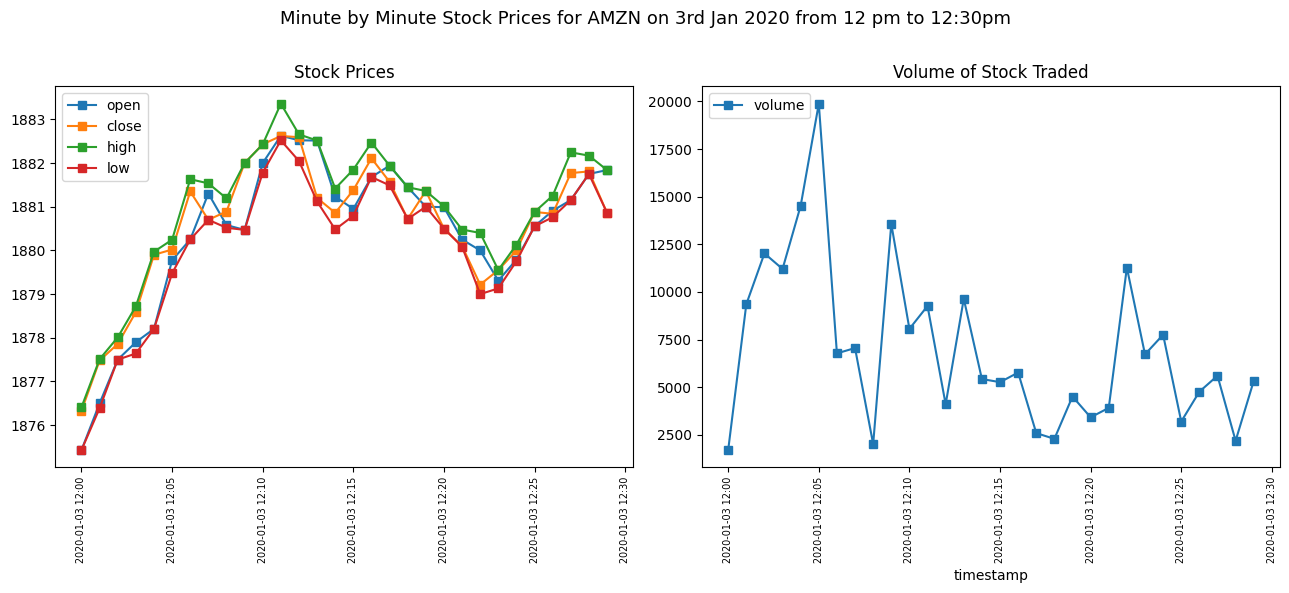

In [5]:
for i in chosen_stocks:
  df = get_subset_of_dataset(i, start_date='2020-01-03 12:00:00', end_date='2020-01-03 12:30:00')
  visualize_stock_prices_min(df, f"Minute by Minute Stock Prices for {i} on 3rd Jan 2020 from 12 pm to 12:30pm")


## 1b) Day by Day Closing Price for Few Stocks

In [6]:
def visualize_stock_prices_day(df, title):
    df.set_index('datetime', inplace=True)
    daily_closing = df.resample('D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', "volume" : "sum"})

    fig, axes = plt.subplots(2, 1, figsize=(13, 10), sharex=True)
    column_names=['open', 'close', 'high', 'low']

    for i, col_name in enumerate(column_names):
      axes[0].plot(df.index, df[col_name], label=col_name)

    axes[0].set_title("Stock Prices")
    dtFmt = mdates.DateFormatter('%Y-%m-%d %H:%M')
    axes[0].xaxis.set_major_formatter(dtFmt)
    axes[0].xaxis.set_tick_params(rotation=90, labelsize='x-small')
    axes[0].legend(loc='upper left')

    axes[1].plot(df.index, df['volume'], label='volume')
    axes[1].set_title("Volume of Stock Traded")
    dtFmt = mdates.DateFormatter('%Y-%m-%d %H:%M')
    axes[1].xaxis.set_major_formatter(dtFmt)
    axes[1].xaxis.set_tick_params(rotation=90, labelsize='x-small')
    axes[1].legend(loc='upper left')

    plt.xlabel("timestamp")
    plt.suptitle(title, fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust subplot layout
    plt.show()

### Let us print for the case of the month of January 2020

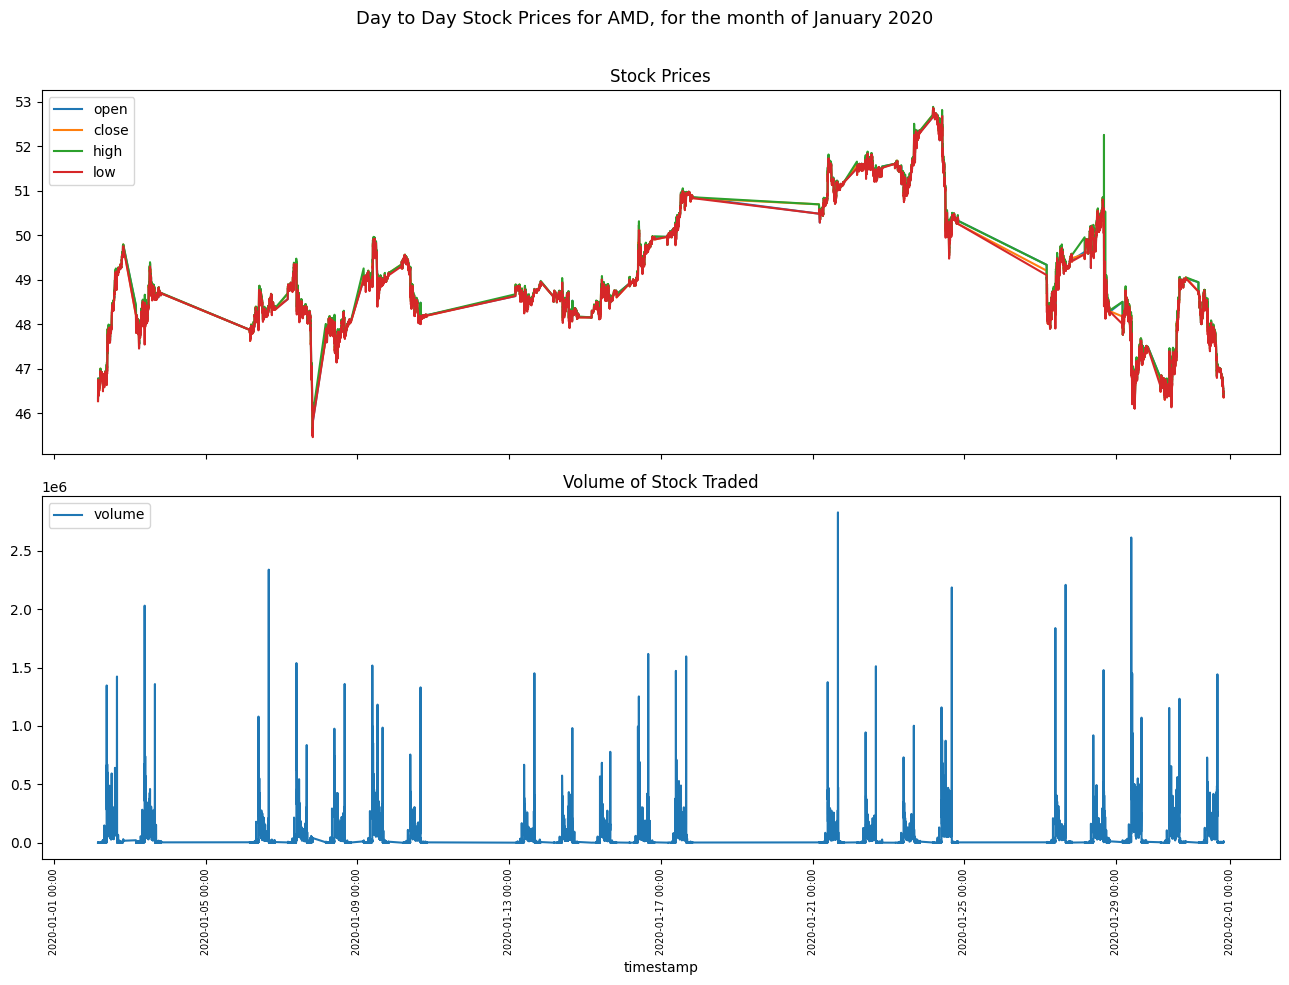

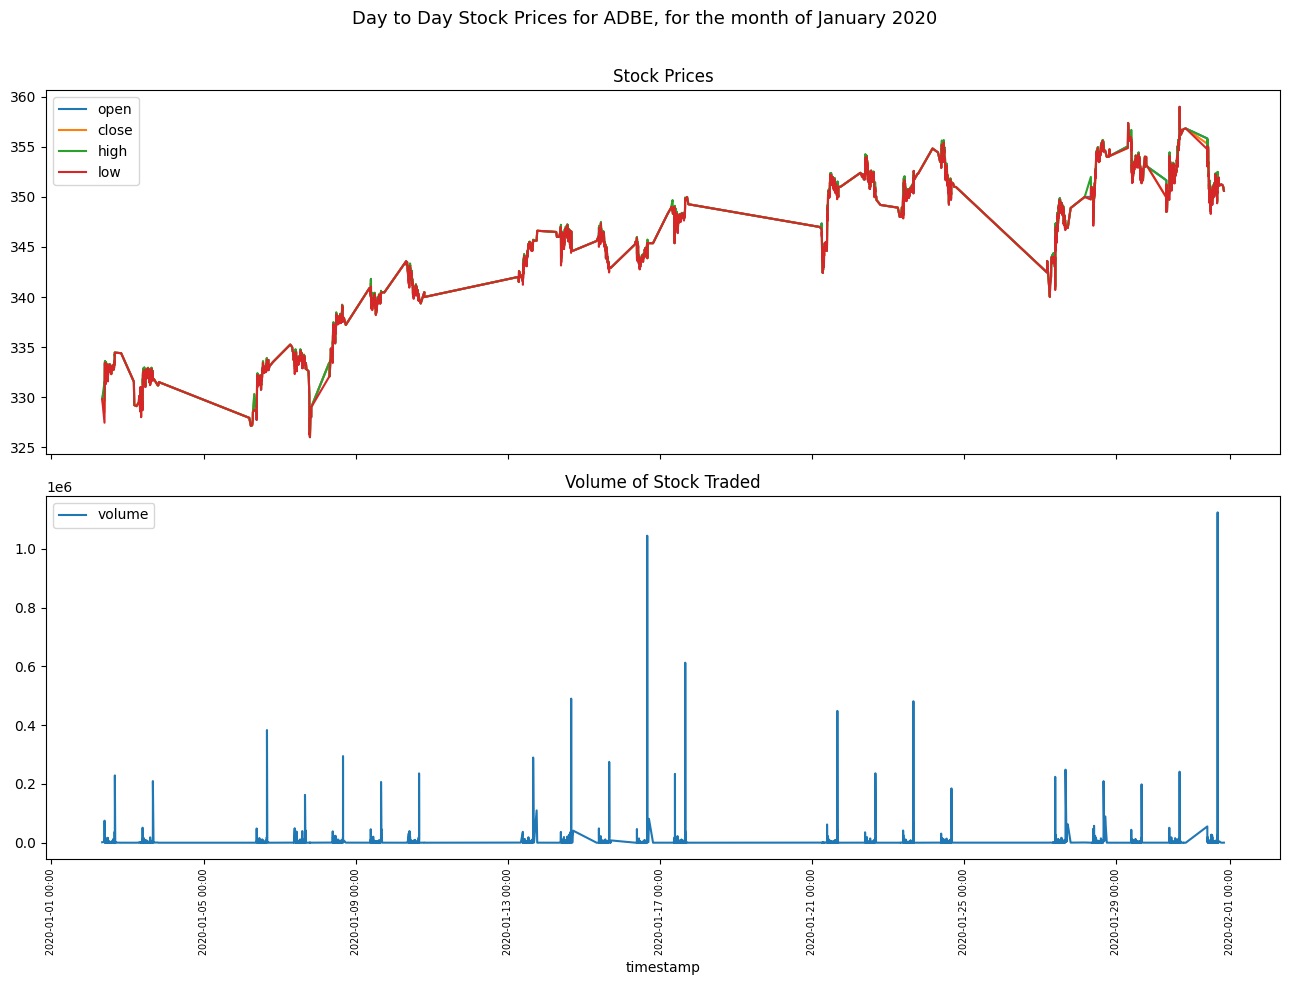

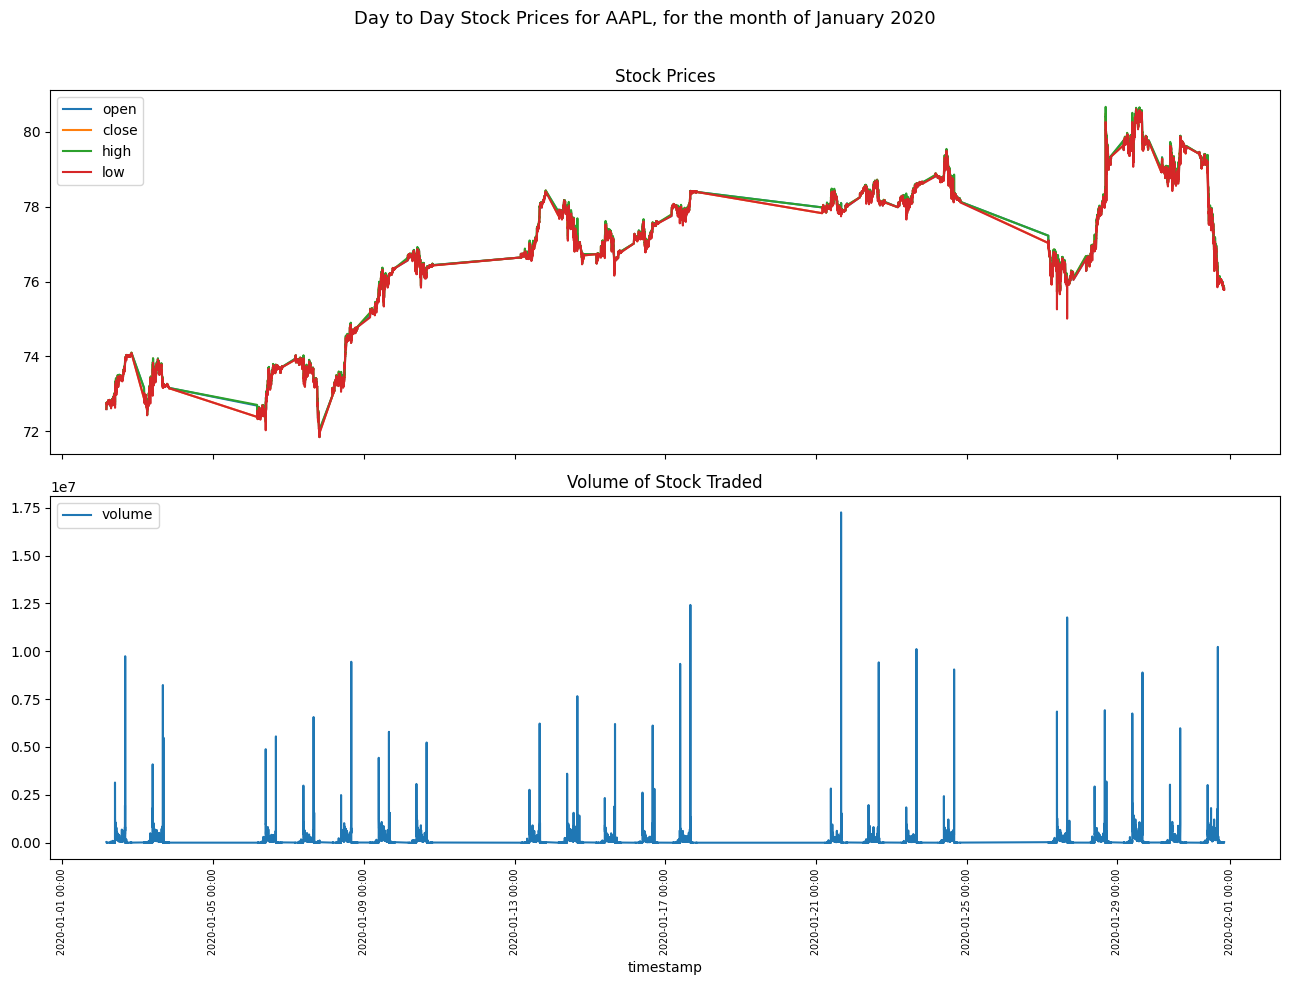

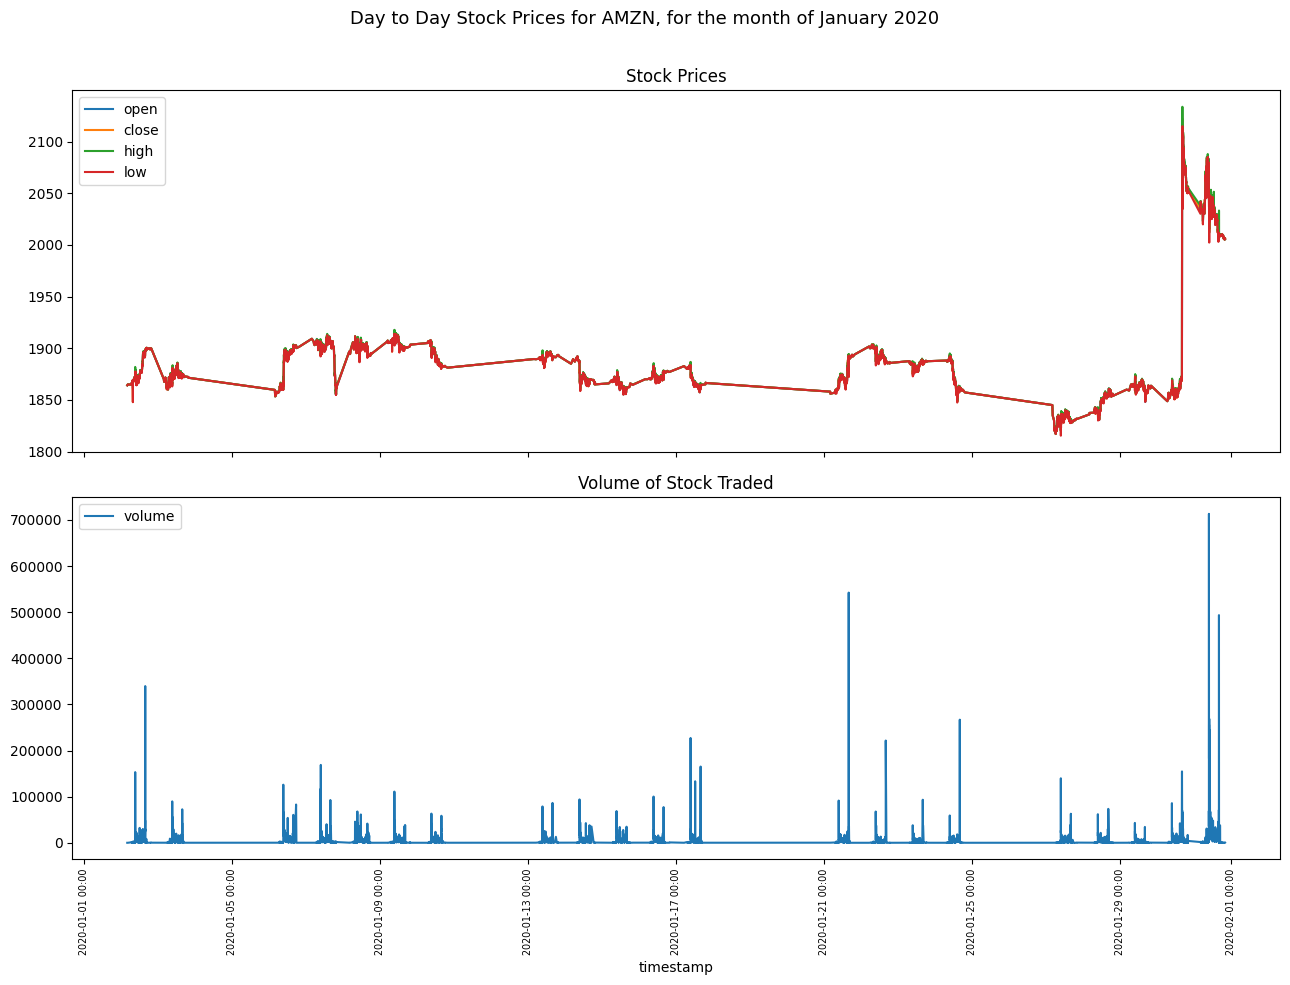

In [7]:
for i in chosen_stocks:
  df = get_subset_of_dataset(i, start_date='2020-01-01 00:00:00', end_date='2020-01-31 23:59:00')
  visualize_stock_prices_day(df, f"Day to Day Stock Prices for {i}, for the month of January 2020")

## 1c) Plotting candlestick chart with volume on secondary y-axis
- We will use the python library mplfinance by matplotlib for plotting candlestick charts

In [8]:
!pip install mplfinance

### Let us plot for the first quarter of 2019

In [9]:
import pandas as pd
import mplfinance as mpf

def visualize_stock_candlestick(df, title):
    df.set_index('datetime', inplace=True)
    daily_closing = df.resample('D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', "volume" : "sum"})
    fig, axes = mpf.plot(daily_closing, type='candle', style='yahoo', title=title, ylabel='Price', volume=True, figsize=(15, 8), returnfig=True)
    axes[1].set_ylabel('Volume')
    mpf.show()

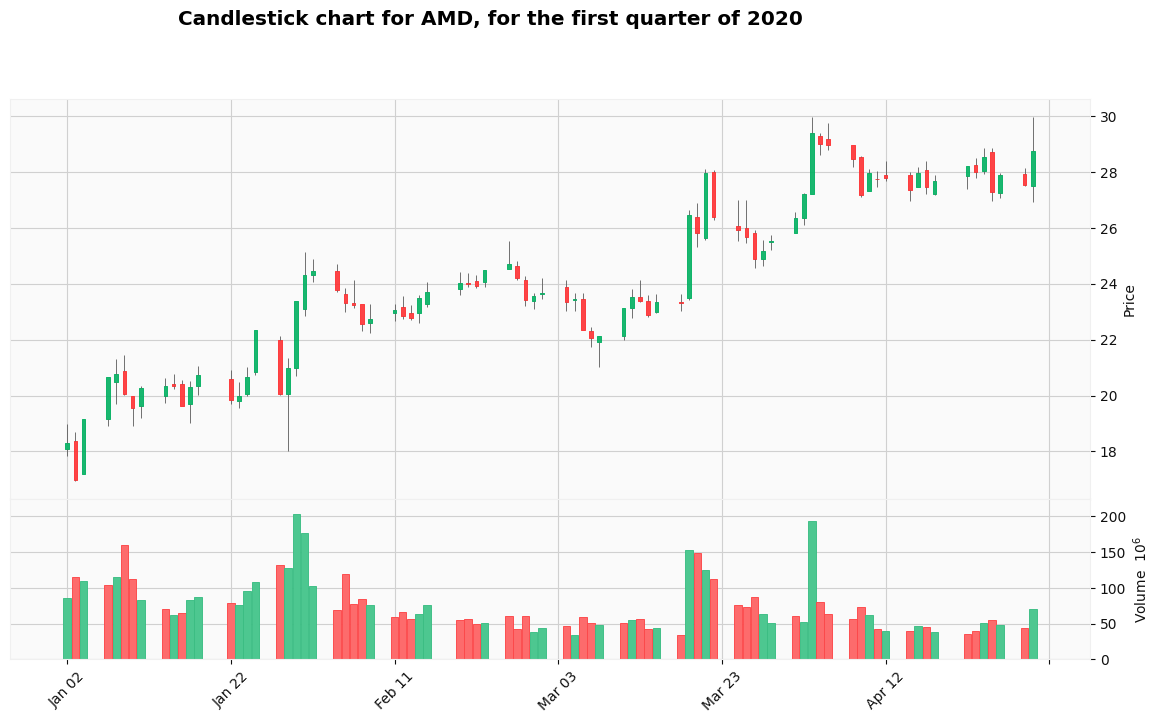

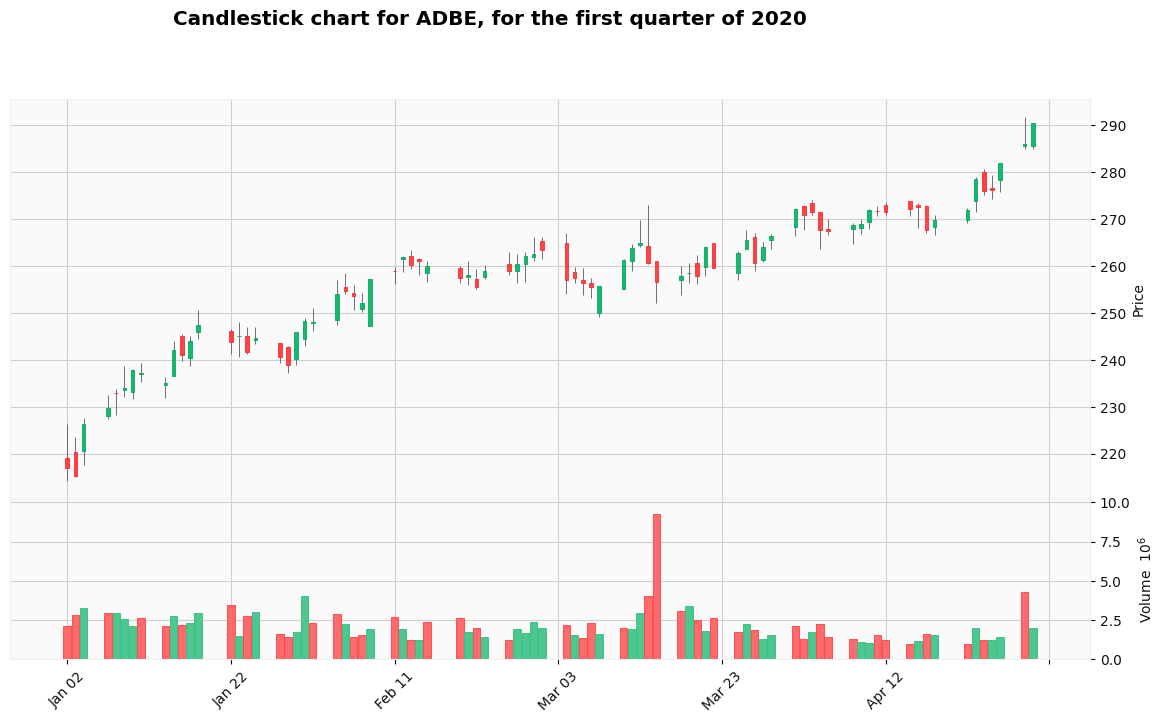

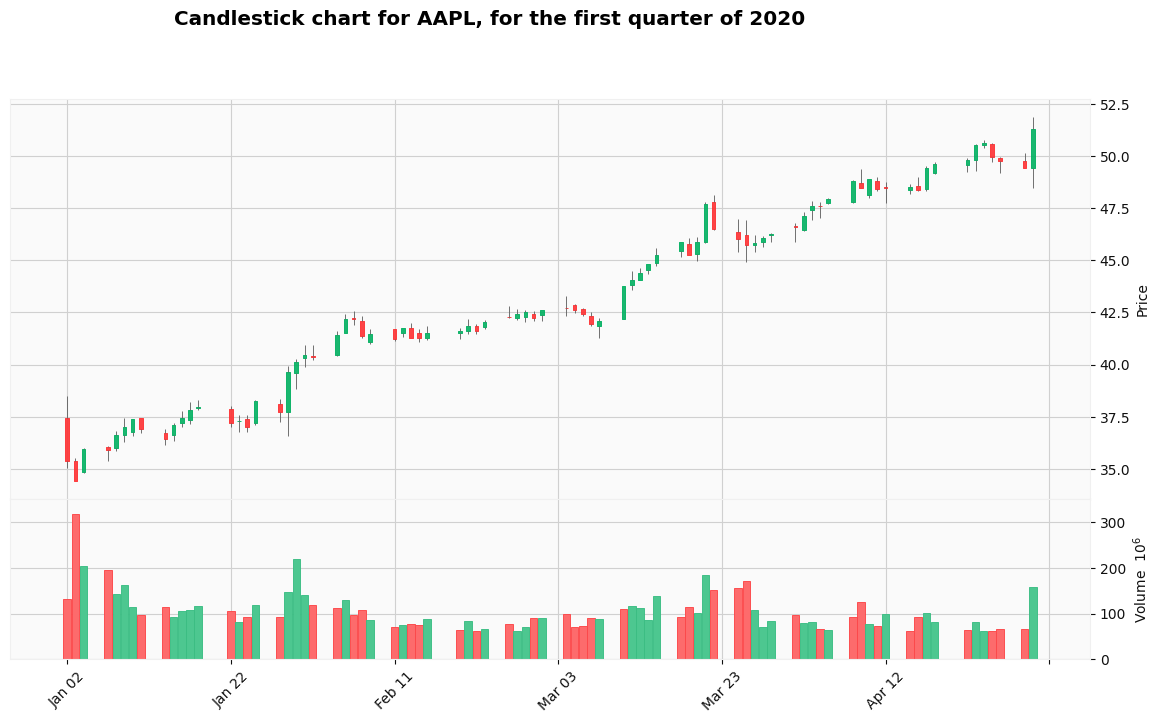

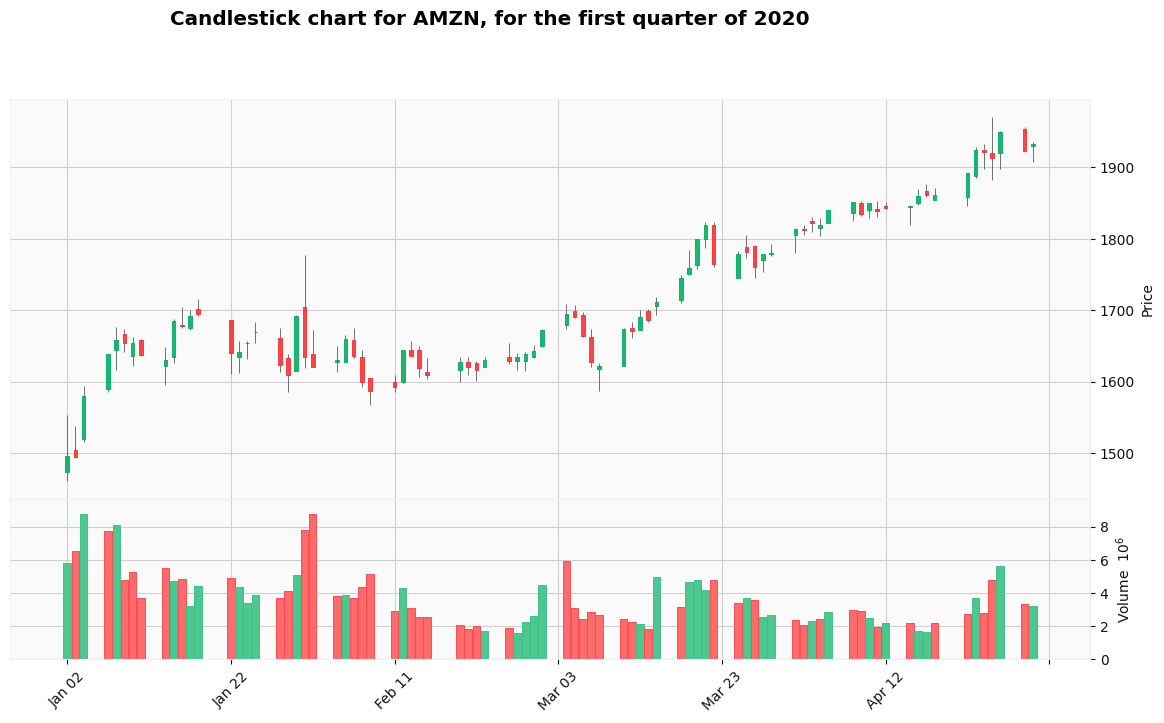

In [10]:
for i in chosen_stocks:
  df = get_subset_of_dataset(i, start_date='2019-01-01 00:00:00', end_date='2019-04-30 23:59:00')
  visualize_stock_candlestick(df, f"Candlestick chart for {i}, for the first quarter of 2020")

## 1d) Observations of Data

We can see the following things, which have been explained below with some plot image example




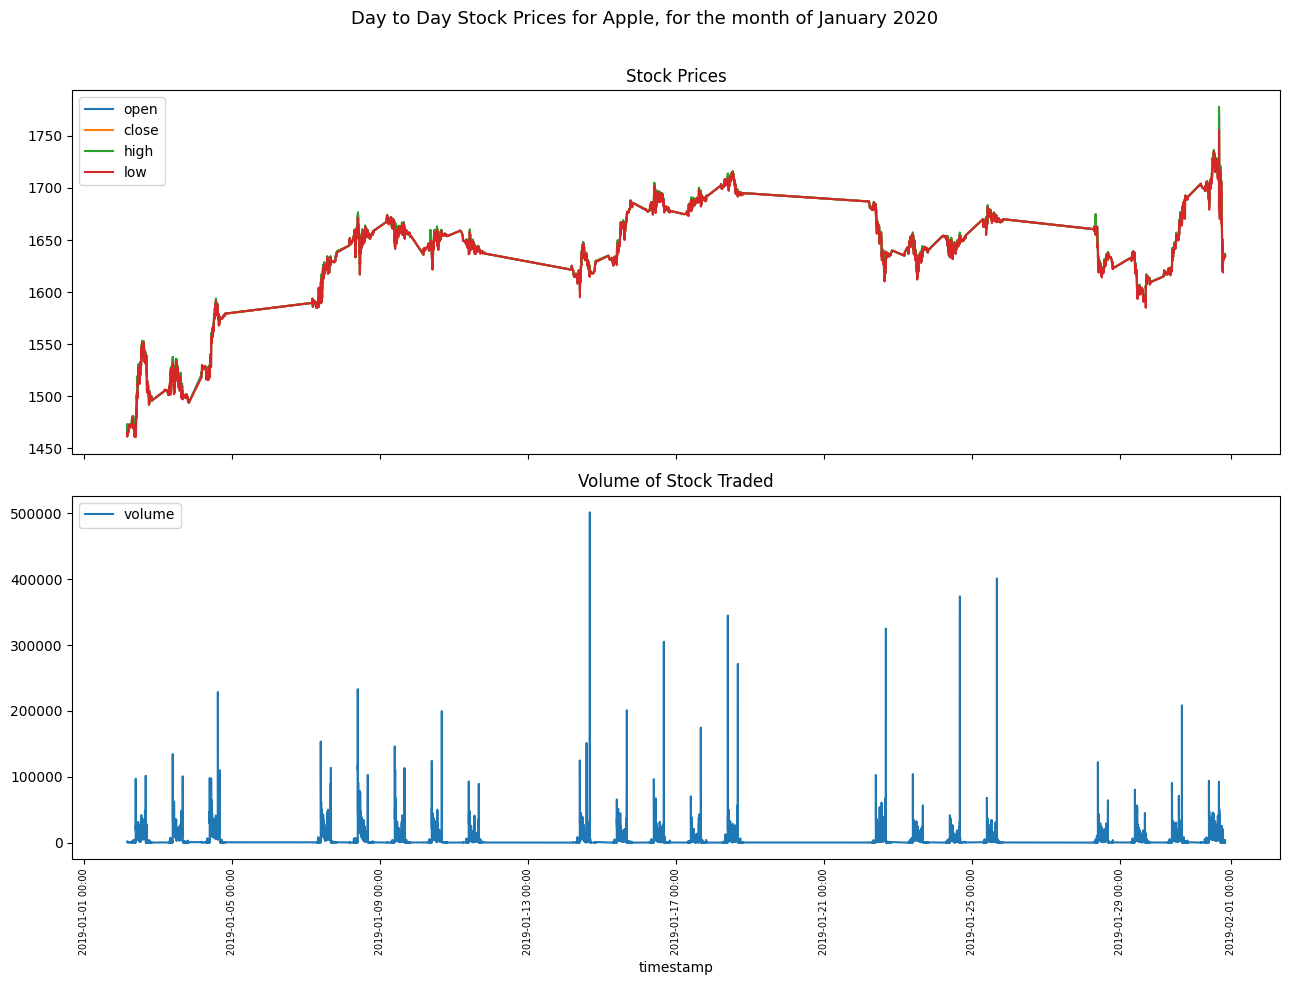

In [11]:
plt.style.use('default')
df = get_subset_of_dataset(i, start_date='2019-01-01 00:00:00', end_date='2019-01-31 23:59:00')
visualize_stock_prices_day(df, f"Day to Day Stock Prices for Apple, for the month of January 2020")

- See above figure : There are a few days for which the data is missing, for example in the case of study of a stock for a month, we will see abrupt jumps, indicating missing data for some days (this may be because of holidays)
- While training the LSTM, we will ignore these jumps and consider it to be a single continuous time series


## 2) Normalizing Stock Data
Two ways in which we can normalize stock data is using
- Min-Max Scaling : the relative relationships between stock prices and volumes fall within the same range, thus we can compare stocks across different companies and time periods

- Z score Scaling : we transform data to have a mean of 0 and a standard deviation of 1, centering the data around a common mean and express values in terms of standard deviations from the mean.

We will use normalizers from sklearn.preprocessing, we will need seperate normalizers for volume and stock prices

Let us take the data for the first quarter of 2020

In [12]:
mm_company_wise = {}

for i in chosen_stocks:
  mm_company_wise[i] = get_subset_of_dataset(i, start_date='2020-01-01 00:00:00', end_date='2020-04-30 23:59:00')

combined_data = pd.concat(list(mm_company_wise.values()), axis=0, ignore_index=True)
price_columns = ['open', 'high', 'low', 'close']
volume_columns = ['volume']

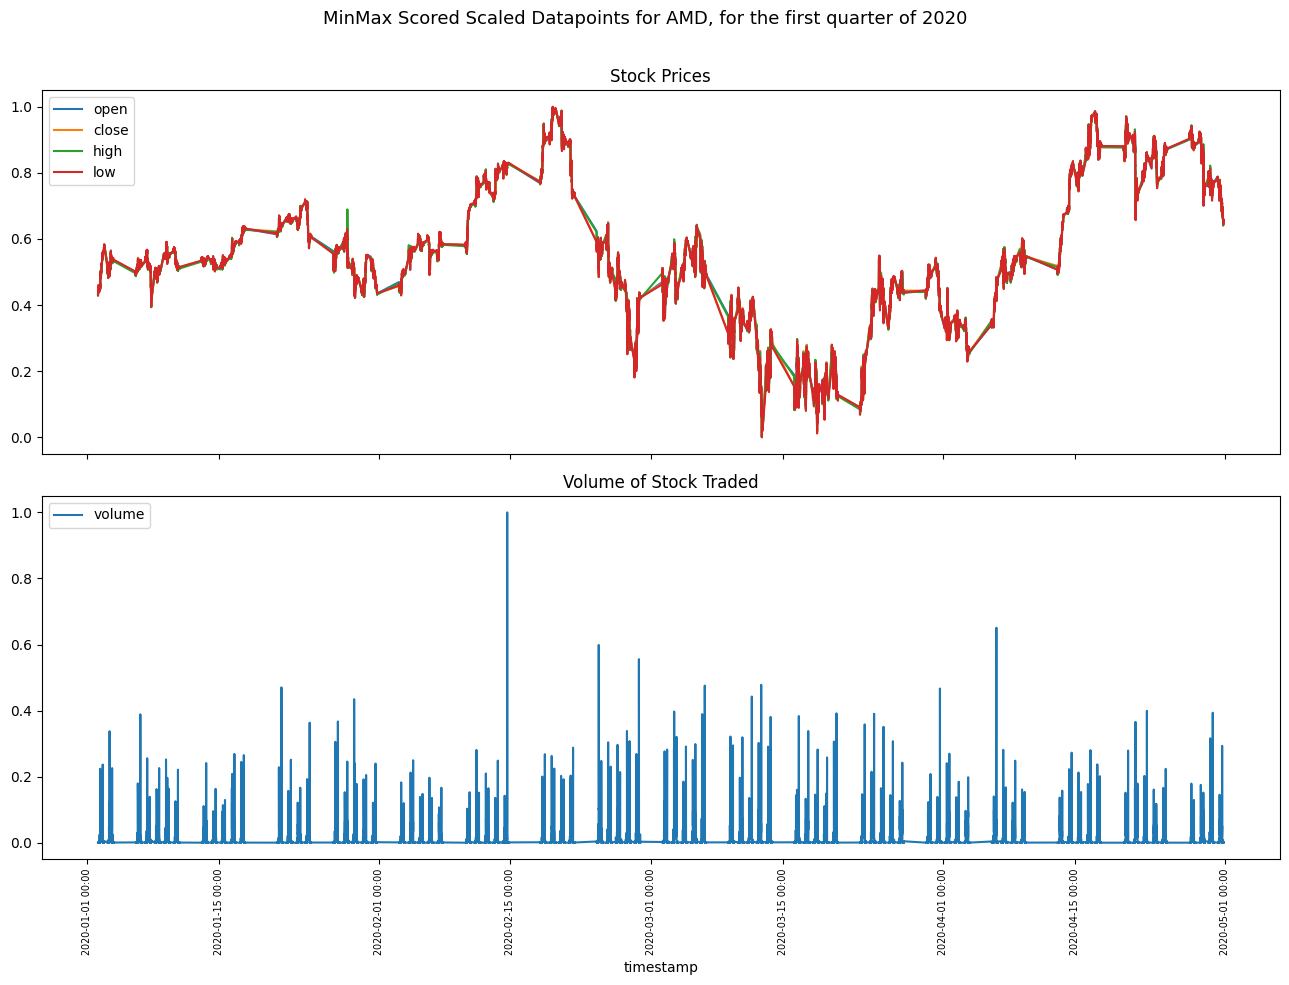

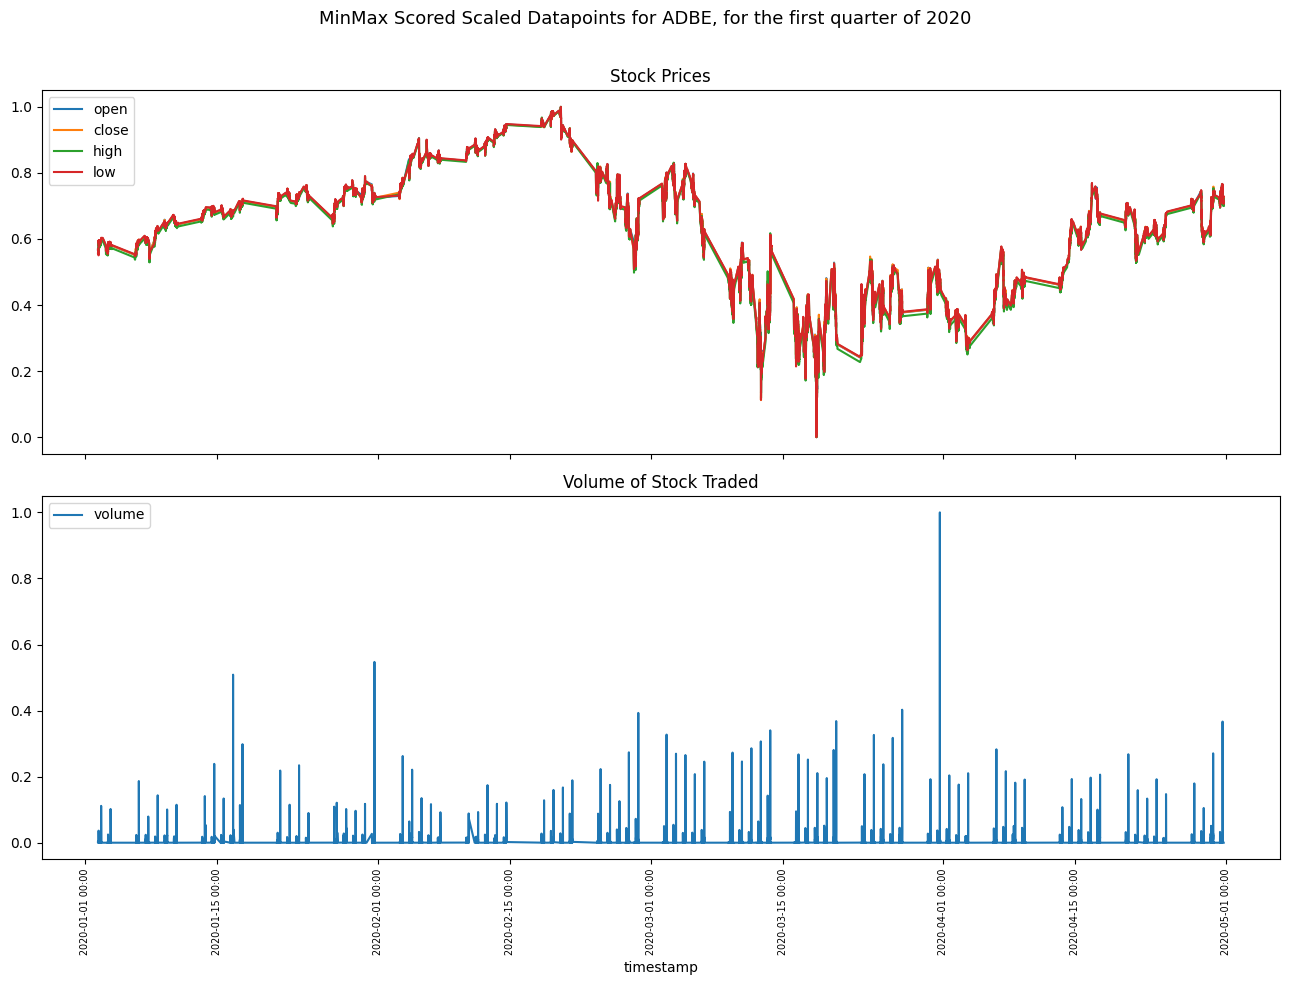

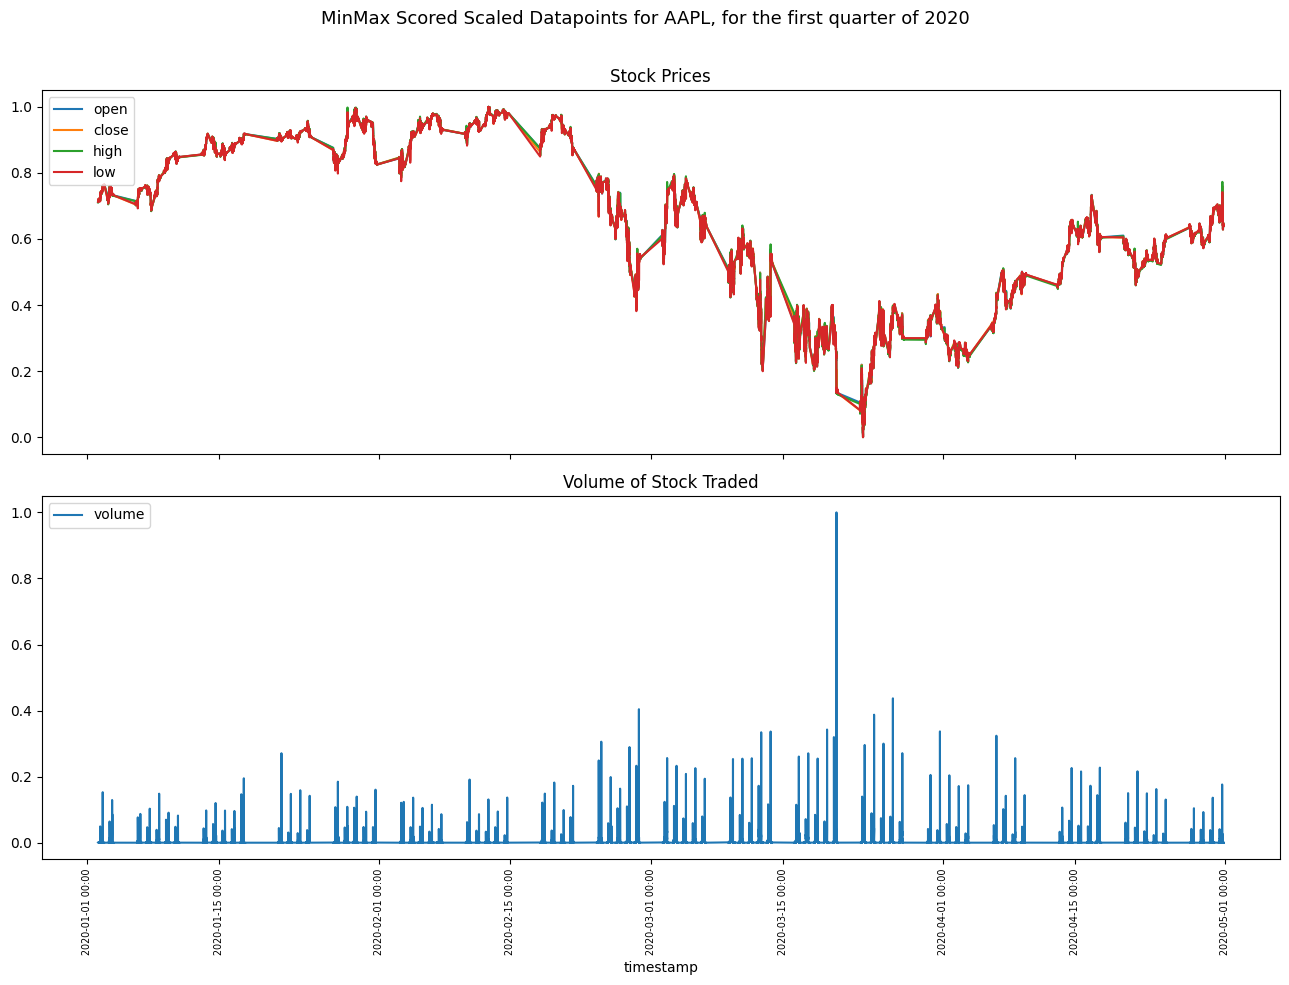

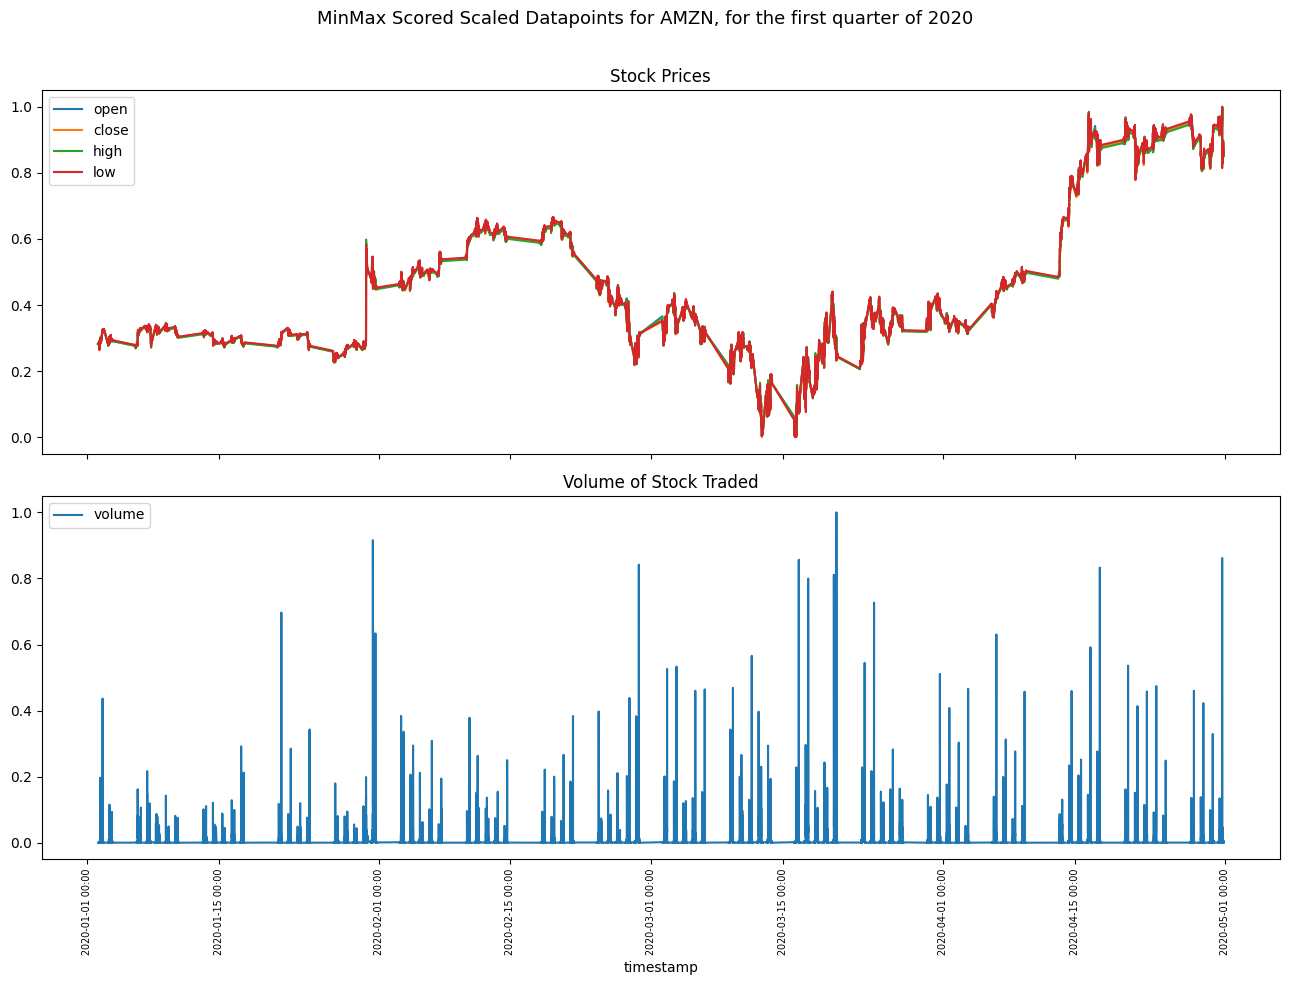

In [13]:
from sklearn.preprocessing import MinMaxScaler

mm_price_scaler = MinMaxScaler()
mm_volume_scaler = MinMaxScaler()

mm_price_scaler.fit(combined_data[price_columns])
mm_volume_scaler.fit(combined_data[volume_columns])

for i in chosen_stocks:
  mm_company_wise[i][['open', 'close', 'low', 'high']] = mm_price_scaler.fit_transform(mm_company_wise[i][['open', 'close', 'low', 'high']])
  mm_company_wise[i]['volume'] = mm_volume_scaler.fit_transform(mm_company_wise[i][['volume']])
  visualize_stock_prices_day(mm_company_wise[i], f"MinMax Scored Scaled Datapoints for {i}, for the first quarter of 2020")

In [14]:
z_company_wise = {}

for i in chosen_stocks:
  z_company_wise[i] = get_subset_of_dataset(i, start_date='2020-01-01 00:00:00', end_date='2020-04-30 23:59:00')

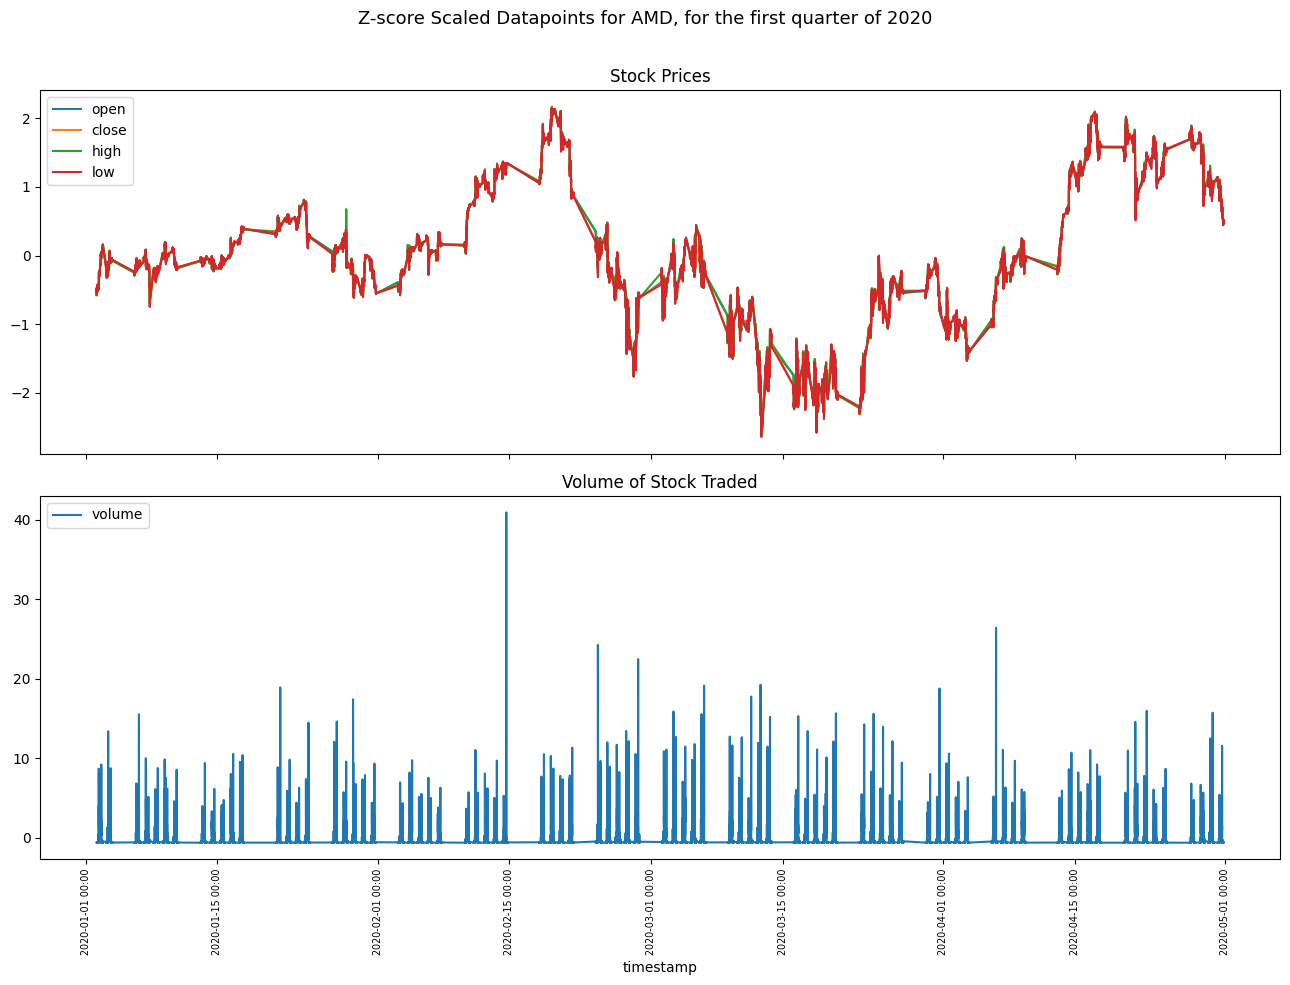

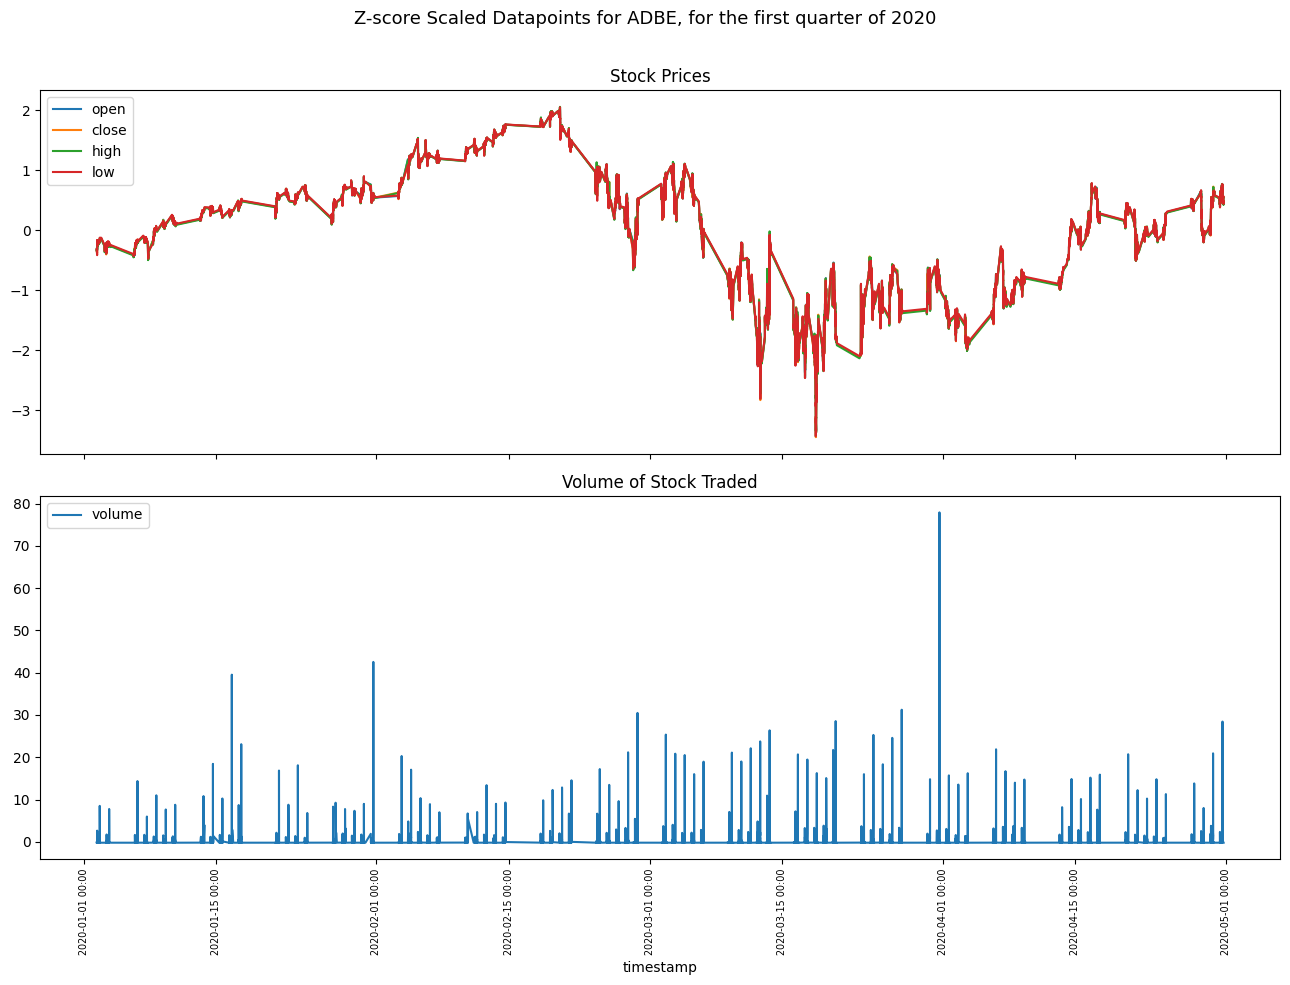

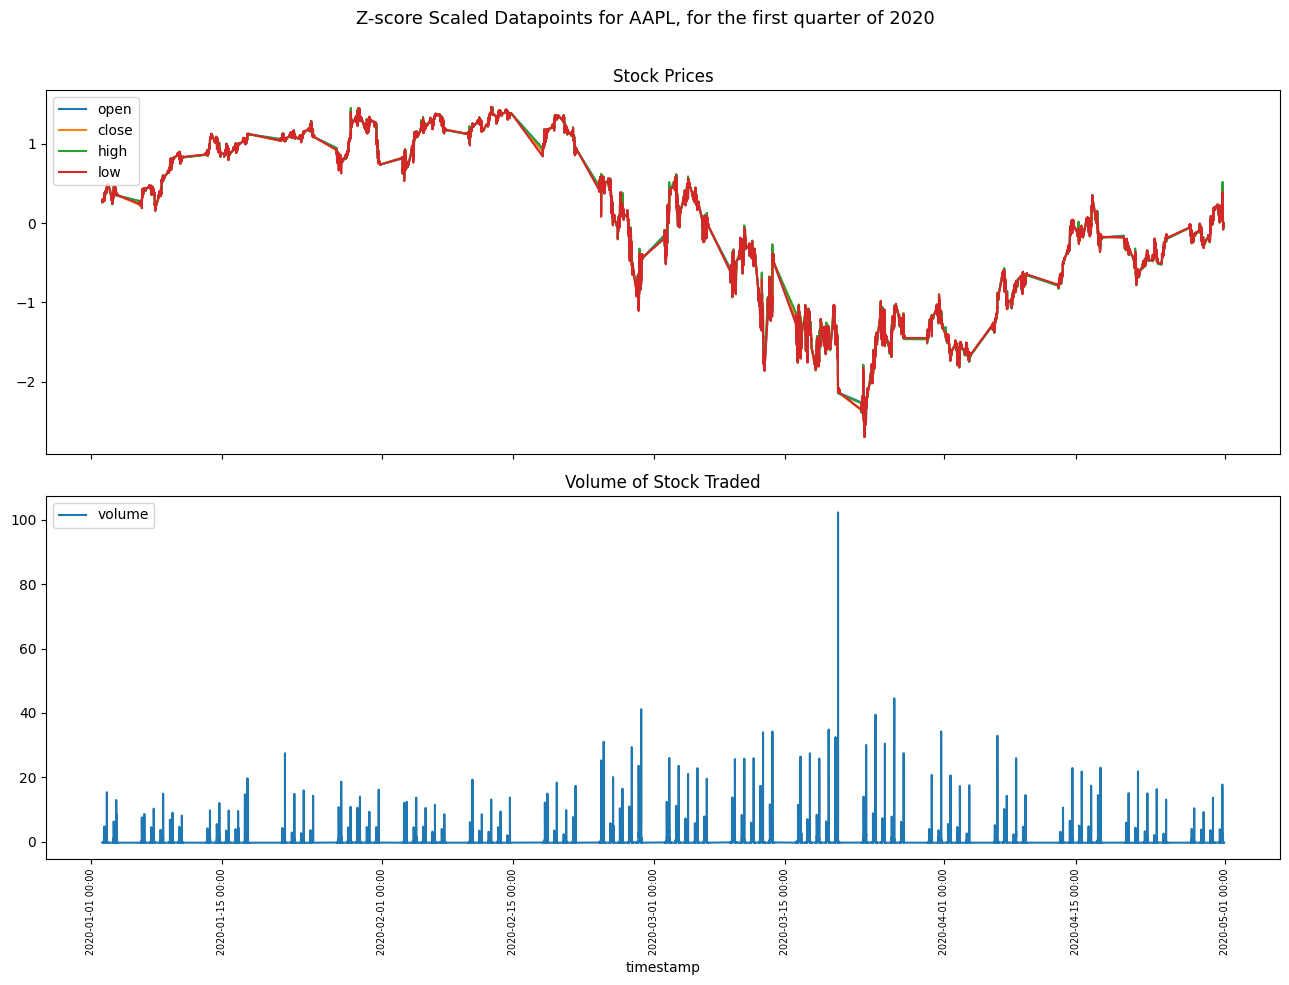

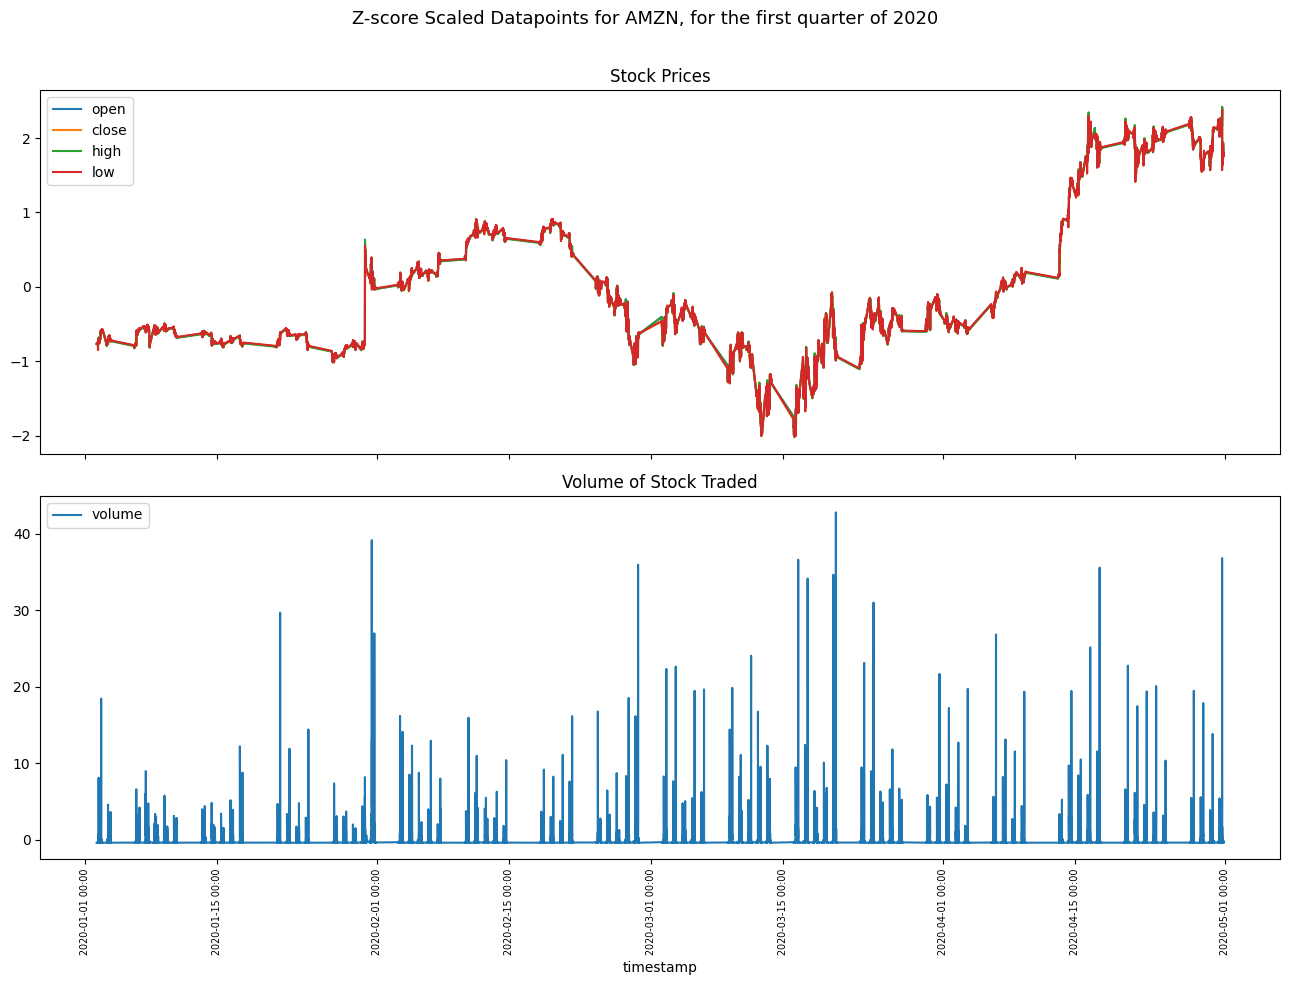

In [15]:
from sklearn.preprocessing import StandardScaler

z_price_scaler = StandardScaler()
z_volume_scaler = StandardScaler()

z_price_scaler.fit(combined_data[price_columns])
z_volume_scaler.fit(combined_data[volume_columns])

for i in chosen_stocks:
  z_company_wise[i][['open', 'close', 'low', 'high']] = z_price_scaler.fit_transform(z_company_wise[i][['open', 'close', 'low', 'high']])
  z_company_wise[i]['volume'] = z_volume_scaler.fit_transform(z_company_wise[i][['volume']])
  visualize_stock_prices_day(z_company_wise[i], f"Z-score Scaled Datapoints for {i}, for the first quarter of 2020")

## 2) Methodology for choosing the Scaling Method for various Scenarios

- For high-frequency trading (intra-day-trading), price and volume can fluctuate rapidly, in such cases Z-score would be more better than MaxMin, as it scales on the basis of mean and standard deviation and can capture short term variations better (Z-score better in this case)

- For inter-day or long term, MinMax scaling would be better, since this scaling maintains the relative differences stable for longer time periods (MinMax better in this case)

- If we allow trading simulation to account for buy-ask spreads (related to volume and price) and commissions then Z-score normalization can keep the relative significance of spreads and commissions, while Min-Max scaling cannot account for this information
(Z-score better in this case)

- Z-score normalization makes it easier to compare the relative importance of price and volume changes across different assets.

### **Seeing that the advantages of using Z-score Normalization outweigh for the application which we plan to target (see below), we will proceed with Z-score normalization**

## 3) Final Assumption Decisions
- ### **We will perform High Frequency Trading (Intra-day) where we trade after a said time of $m$ minutes (for example once every 10 minutes)**
- ### **Using one/some/all (we can try all one-by-one) stocks from the Tech basket (which is why DELL, CSCO, ADBE, AAPL, AMZN, AMD were chosen)**
  - We will predict AAPL stock price only using AAPL closing price, AAPL all parameters (close, open, high, low, volume) and also another example (see Q9) where we consider correlated stocks AAPL and AMD  
- ### **After a quick research online, we assume buy-ask spread and commissions for each trade as the following**
  - The commission per trade is **1 USD** (it is lower for HFT than daily since the frequency of trade is higher in this case) and the buy ask spread is **5 cents** (average values used for high frequency trading in NYSE as per the internet)


## 4) PyTorch Module LSTM  
[Reference Implementation Followed](https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch?scriptVersionId=35329420&cellId=11) : Credits to Ron Saldanha (Kaggle)

In [16]:
import torch
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

## Strategy to combine various company stock data together
- We shall make use of inner joins on the key for example in the bottom case we take common keys of datetime for both stocks to prepare the dataset

In [17]:
df1 = get_subset_of_dataset('AAPL', start_date='2020-01-06 00:00:00', end_date='2020-01-06 9:00:00')
df1.set_index('datetime', inplace=True)

In [18]:
df2 = get_subset_of_dataset('AMZN', start_date='2020-01-06 00:00:00', end_date='2020-01-06 9:00:00')
df2.set_index('datetime', inplace=True)

In [19]:
df1.head()

open     high      low    close  volume
datetime                                                       
2020-01-06 04:00:00  72.6834  72.7031  72.3808  72.3808    5368
2020-01-06 04:01:00  72.3808  72.3808  72.3808  72.3808     732
2020-01-06 04:02:00  72.5235  72.5235  72.5210  72.5210    1200
2020-01-06 04:05:00  72.5210  72.5653  72.5210  72.5653    2000
2020-01-06 04:06:00  72.5087  72.5776  72.5087  72.5776    1996

In [20]:
df2.head()

open     high      low    close  volume
datetime                                                       
2020-01-06 04:00:00  1859.70  1859.70  1859.70  1859.70     294
2020-01-06 04:14:00  1853.39  1853.39  1853.39  1853.39     304
2020-01-06 04:37:00  1854.00  1854.00  1854.00  1854.00     302
2020-01-06 04:40:00  1854.18  1854.18  1854.18  1854.18     241
2020-01-06 04:57:00  1856.18  1856.18  1856.18  1856.18     200

In [21]:
df1 = df1.merge(df2, how='inner', on='datetime')

In [22]:
df1.head()

open_x   high_x    low_x  close_x  volume_x   open_y  \
datetime                                                                     
2020-01-06 04:00:00  72.6834  72.7031  72.3808  72.3808      5368  1859.70   
2020-01-06 04:37:00  72.3857  72.3857  72.3857  72.3857       672  1854.00   
2020-01-06 04:40:00  72.3710  72.3710  72.3685  72.3685      2356  1854.18   
2020-01-06 05:10:00  72.6268  72.6268  72.6268  72.6268      2400  1858.00   
2020-01-06 06:13:00  72.4153  72.4448  72.4153  72.4448      5252  1857.77   

                      high_y    low_y  close_y  volume_y  
datetime                                                  
2020-01-06 04:00:00  1859.70  1859.70  1859.70       294  
2020-01-06 04:37:00  1854.00  1854.00  1854.00       302  
2020-01-06 04:40:00  1854.18  1854.18  1854.18       241  
2020-01-06 05:10:00  1858.00  1858.00  1858.00       100  
2020-01-06 06:13:00  1857.77  1857.77  1857.77       290

Thus we can combine in such a way that the stock price which we want to predict is right in front or in the first column of the dataframe

In [23]:
df = z_company_wise['AAPL'][['close', 'open', 'high', 'low', 'volume']]
df.head()

close      open      high       low    volume
datetime                                                             
2020-01-02 04:00:00  0.265159  0.264029  0.260058  0.269162 -0.263041
2020-01-02 04:06:00  0.283657  0.274907  0.278596  0.280017 -0.311308
2020-01-02 04:08:00  0.282198  0.282159  0.277134  0.287253 -0.312726
2020-01-02 04:09:00  0.289464  0.289057  0.284416  0.294137 -0.308446
2020-01-02 04:10:00  0.284011  0.283972  0.278951  0.289062 -0.308962

In [24]:
df_np = df.to_numpy()
df_np[:5, :]

array([[ 0.26515918,  0.26402944,  0.2600582 ,  0.26916212, -0.26304127],
       [ 0.28365679,  0.27490713,  0.27859647,  0.28001674, -0.31130818],
       [ 0.28219762,  0.28215892,  0.27713409,  0.28725316, -0.31272628],
       [ 0.28946401,  0.28905697,  0.28441645,  0.29413657, -0.3084462 ],
       [ 0.28401053,  0.28397187,  0.27895099,  0.28906226, -0.30896187]])

In [25]:
data = []
window_size = 4
for index in range(len(df_np) - window_size):
  data.append(df_np[index : index + window_size])
data = np.array(data)
x_train = data[:1,:-1,:]
y_train = data[:1,-1,0].reshape(-1, 1)

In [26]:
x_train

array([[[ 0.26515918,  0.26402944,  0.2600582 ,  0.26916212,
         -0.26304127],
        [ 0.28365679,  0.27490713,  0.27859647,  0.28001674,
         -0.31130818],
        [ 0.28219762,  0.28215892,  0.27713409,  0.28725316,
         -0.31272628]]])

In [27]:
y_train

array([[0.28946401]])

## 5) Flexible Dataloader for training the LSTM

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'target': self.targets[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

class LSTMTrainDataLoader():
  def __init__(self, companies, start_timestamp, end_timestamp):
    self.companies = companies
    self.z_company_wise = {}
    self.z_price_scaler = StandardScaler()
    self.z_volume_scaler = StandardScaler()

    for i in companies:
      z_company_wise[i] = get_subset_of_dataset(i, start_date=start_timestamp, end_date=end_timestamp)
      z_company_wise[i].set_index('datetime', inplace=True)

    combined_data = pd.concat(list(z_company_wise.values()), axis=0, ignore_index=True)
    price_columns = ['open', 'high', 'low', 'close']
    volume_columns = ['volume']

    z_price_scaler.fit(combined_data[price_columns])
    z_volume_scaler.fit(combined_data[volume_columns])

    for i in companies:
      z_company_wise[i][['open', 'close', 'low', 'high']] = z_price_scaler.fit_transform(z_company_wise[i][['open', 'close', 'low', 'high']])
      z_company_wise[i]['volume'] = z_volume_scaler.fit_transform(z_company_wise[i][['volume']])


  def generate_dataset(self, company, other_companies_to_include = [], input_rows = ['close'], train_ratio=0.7, validation_ratio=0.15, test_ratio=0.15, window_size=20, batch_size=32, shuffle=False):
    # first column name in input_rows should be the stock which we want to predict, generally close
    df = z_company_wise[company][input_rows]

    if len(other_companies_to_include) > 0:
      for comp in other_companies_to_include:
        new_df = z_company_wise[comp][input_rows]
        df = df.merge(new_df, how='inner', on='datetime')

    df_np = df.to_numpy()
    print(df_np.shape)
    data = []

    for index in range(len(df_np) - window_size):
        data.append(df_np[index : index + window_size])

    data = np.array(data)
    test_set_size = int(np.round(test_ratio*data.shape[0]))
    validation_set_size = int(np.round(validation_ratio*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size) - (validation_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,0].reshape(-1, 1)

    x_test = data[train_set_size: train_set_size + validation_set_size,:-1,:]
    y_test = data[train_set_size: train_set_size + validation_set_size,-1,0].reshape(-1, 1)

    x_valid = data[train_set_size + validation_set_size : ,:-1, :]
    y_valid = data[train_set_size + validation_set_size : ,-1,0].reshape(-1, 1)

    self.x_train = torch.from_numpy(x_train).type(torch.Tensor)
    self.x_test = torch.from_numpy(x_test).type(torch.Tensor)
    self.y_train = torch.from_numpy(y_train).type(torch.Tensor)
    self.y_test = torch.from_numpy(y_test).type(torch.Tensor)
    self.x_valid = torch.from_numpy(x_valid).type(torch.Tensor)
    self.y_valid = torch.from_numpy(y_valid).type(torch.Tensor)

    self.train_data = TimeSeriesDataset(self.x_train, self.y_train)
    self.test_data = TimeSeriesDataset(self.x_test, self.y_test)
    self.valid_data = TimeSeriesDataset(self.x_valid, self.y_valid)

    print("X : train_shape:",x_train.shape, "test_shape:", x_test.shape, "valid_shape:", x_valid.shape)
    print("Y : train_shape", y_train.shape, "test_shape:", y_test.shape, "valid_shape:", y_valid.shape)

    self.train_dataloader = DataLoader(self.train_data, batch_size=batch_size, shuffle=shuffle)
    self.test_dataloader = DataLoader(self.test_data, batch_size=batch_size, shuffle=shuffle)
    self.valid_dataloader = DataLoader(self.valid_data, batch_size=batch_size, shuffle=shuffle)
    print("Dataloader Created Successfully")

### Some Examples

In [29]:
dataloader = LSTMTrainDataLoader(['AAPL'], '2019-01-01 00:00:00', '2019-01-06 23:59:59')
dataloader.generate_dataset('AAPL', [], ['close', 'open'])

(2492, 2)
X : train_shape: (1730, 19, 2) test_shape: (371, 19, 2) valid_shape: (371, 19, 2)
Y : train_shape (1730, 1) test_shape: (371, 1) valid_shape: (371, 1)
Dataloader Created Successfully


In [30]:
dataloader = LSTMTrainDataLoader(['AAPL', 'AMZN'], '2019-01-01 00:00:00', '2019-01-06 23:59:59')
dataloader.generate_dataset('AAPL', [], ['close', 'open', 'high', 'low'])

(2492, 4)
X : train_shape: (1730, 19, 4) test_shape: (371, 19, 4) valid_shape: (371, 19, 4)
Y : train_shape (1730, 1) test_shape: (371, 1) valid_shape: (371, 1)
Dataloader Created Successfully


In [31]:
dataloader = LSTMTrainDataLoader(['AAPL', 'AMZN'], '2019-01-01 00:00:00', '2019-01-06 23:59:59')
dataloader.generate_dataset('AAPL', ['AMZN'], ['close'])

(1678, 2)
X : train_shape: (1160, 19, 2) test_shape: (249, 19, 2) valid_shape: (249, 19, 2)
Y : train_shape (1160, 1) test_shape: (249, 1) valid_shape: (249, 1)
Dataloader Created Successfully


In [32]:
dataloader = LSTMTrainDataLoader(['AAPL', 'AMZN'], '2019-01-01 00:00:00', '2019-01-06 23:59:59')
dataloader.generate_dataset('AAPL', ['AMZN'], ['close', 'open', 'high', 'low'])

(1678, 8)
X : train_shape: (1160, 19, 8) test_shape: (249, 19, 8) valid_shape: (249, 19, 8)
Y : train_shape (1160, 1) test_shape: (249, 1) valid_shape: (249, 1)
Dataloader Created Successfully


## 6) Predicting Close Price for Single Company (AAPL) only using its Close Price as input
- We will train the data on the data for a quarter (4 months) and predict it for the next quarter

In [33]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100
batch_size = 64

In [34]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adagrad(model.parameters(), lr=0.005)
model

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [35]:
dataloader = LSTMTrainDataLoader(['AAPL'], '2020-01-01 00:00:00', '2020-04-30 23:59:59')

In [36]:
dataloader.generate_dataset('AAPL', [], ['close'], batch_size=batch_size, shuffle=True, window_size=25)

(65672, 1)
X : train_shape: (45953, 24, 1) test_shape: (9847, 24, 1) valid_shape: (9847, 24, 1)
Y : train_shape (45953, 1) test_shape: (9847, 1) valid_shape: (9847, 1)
Dataloader Created Successfully


In [37]:
import time

def train_model(model, num_epochs, dataloader, patience):
  hist = np.zeros(num_epochs)
  start_time = time.time()
  prev_time = start_time
  best_val_loss = np.inf


  train_loader = dataloader.train_dataloader
  valid_loader = dataloader.valid_dataloader

  for t in range(num_epochs):
      train_loss = 0.0
      for batch in train_loader:
        y_train_pred = model(batch['data'])
        loss = criterion(y_train_pred, batch['target'])
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        train_loss += loss.item()
      train_loss /= len(train_loader)

      val_loss = 0.0
      for batch in valid_loader:
        y_val_pred = model(batch['data'])
        loss = criterion(y_val_pred, batch['target'])
        val_loss += loss.item()
      val_loss /= len(train_loader)

      curr_time = time.time()
      print("Epoch ", t, "Train MSE: ", train_loss, "Validation MSE: ", val_loss, "Time taken for Epoch:", curr_time - prev_time)
      prev_time = curr_time
      hist[t] = train_loss

      if val_loss < best_val_loss:
          best_val_loss = val_loss
          no_improvement_count = 0
      else:
          no_improvement_count += 1

      if no_improvement_count >= patience:
          print(f'Early stopping after {patience} epochs of no improvement.')
          break

  training_time = time.time()-start_time
  print("Training time: {}".format(training_time))
  return hist

In [39]:
hist = train_model(model, num_epochs, dataloader, 10)

Epoch  0 Train MSE:  0.0009922316693037007 Validation MSE:  0.00011085877362580423 Time taken for Epoch: 4.021486282348633
Epoch  1 Train MSE:  0.0009180579524198566 Validation MSE:  7.495438915716876e-05 Time taken for Epoch: 4.051217317581177
Epoch  2 Train MSE:  0.0008771701244153575 Validation MSE:  7.190379978452908e-05 Time taken for Epoch: 5.5083372592926025
Epoch  3 Train MSE:  0.000847993073700014 Validation MSE:  0.00010287057741863138 Time taken for Epoch: 3.8010103702545166
Epoch  4 Train MSE:  0.0008207291121355301 Validation MSE:  7.174350428560124e-05 Time taken for Epoch: 4.200981616973877
Epoch  5 Train MSE:  0.0007927329965587964 Validation MSE:  9.591020555063818e-05 Time taken for Epoch: 5.422083616256714
Epoch  6 Train MSE:  0.0007777440584551606 Validation MSE:  8.442594218993967e-05 Time taken for Epoch: 4.512333869934082
Epoch  7 Train MSE:  0.0007581687196193817 Validation MSE:  0.00011726179111118122 Time taken for Epoch: 3.8528597354888916
Epoch  8 Train MSE:

In [40]:
torch.save(model, 'single_feature.pt')

In [41]:
import seaborn as sns

def visualize_train_results(model, dataloader, title, ylabel):
  y_train_pred_np = model(dataloader.x_train).detach().numpy()
  bv = np.ones((1, 4))
  # broadcast because our scaler takes a 4 dim vector, we ultimately will take one column from here
  y_tp_rshp = y_train_pred_np * bv

  y_train_og_np = dataloader.y_train.detach().numpy()
  y_to_rshp = y_train_og_np * bv

  predict = pd.DataFrame(z_price_scaler.inverse_transform(y_tp_rshp))
  original = pd.DataFrame(z_price_scaler.inverse_transform(y_to_rshp))

  sns.set_style("darkgrid")

  fig = plt.figure()
  fig.subplots_adjust(hspace=0.2, wspace=0.2)

  plt.subplot(1, 2, 1)
  # index three because our scaler had closing price at fourth position while training
  ax = sns.lineplot(x = original[3].index, y = original[3], label="Data", color='royalblue')
  ax = sns.lineplot(x = predict[3].index, y = predict[3], label="Training Prediction (LSTM)", color='tomato')
  ax.set_title(title, size = 14, fontweight='bold')
  ax.set_xlabel("Minute", size = 14)
  ax.set_ylabel(ylabel, size = 14)
  ax.set_xticklabels('', size=10)


  plt.subplot(1, 2, 2)
  ax = sns.lineplot(data=hist, color='royalblue')
  ax.set_xlabel("Epoch", size = 14)
  ax.set_ylabel("Loss", size = 14)
  ax.set_title("Training Loss", size = 14, fontweight='bold')
  fig.set_figheight(6)
  fig.set_figwidth(16)

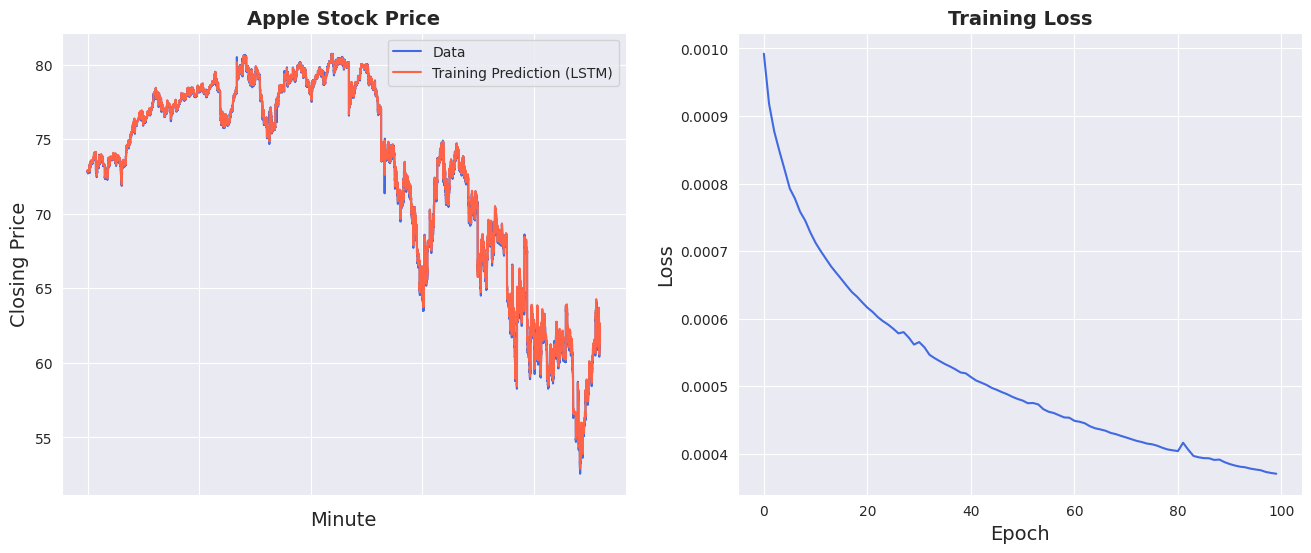

In [42]:
visualize_train_results(model, dataloader, "Apple Stock Price", "Closing Price")

In [43]:
import seaborn as sns

def visualize_train_results_closeup(model, dataloader, title, ylabel):
  y_train_pred_np = model(dataloader.x_train).detach().numpy()
  bv = np.ones((1, 4))
  # broadcast because our scaler takes a 4 dim vector, we ultimately will take one column from here
  y_tp_rshp = y_train_pred_np * bv

  y_train_og_np = dataloader.y_train.detach().numpy()
  y_to_rshp = y_train_og_np * bv

  predict = pd.DataFrame(z_price_scaler.inverse_transform(y_tp_rshp[:200]))
  original = pd.DataFrame(z_price_scaler.inverse_transform(y_to_rshp[:200]))

  sns.set_style("darkgrid")

  fig = plt.figure()
  fig.subplots_adjust(hspace=0.2, wspace=0.2)

  plt.subplot(1, 2, 1)
  # index three because our scaler had closing price at fourth position while training
  ax = sns.lineplot(x = original[3].index, y = original[3], label="Data", color='royalblue')
  ax = sns.lineplot(x = predict[3].index, y = predict[3], label="Training Prediction (LSTM)", color='tomato')
  ax.set_title(title, size = 14, fontweight='bold')
  ax.set_xlabel("Minute", size = 14)
  ax.set_ylabel(ylabel, size = 14)
  ax.set_xticklabels('', size=10)


  plt.subplot(1, 2, 2)
  ax = sns.lineplot(data=hist, color='royalblue')
  ax.set_xlabel("Epoch", size = 14)
  ax.set_ylabel("Loss", size = 14)
  ax.set_title("Training Loss", size = 14, fontweight='bold')
  fig.set_figheight(6)
  fig.set_figwidth(16)

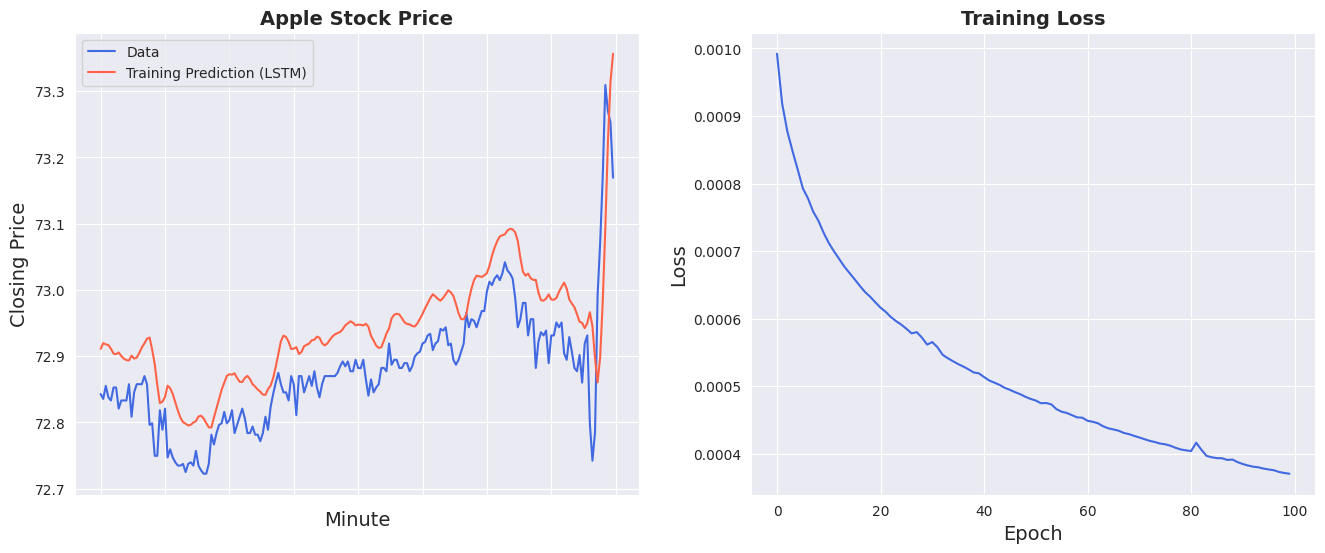

In [44]:
visualize_train_results_closeup(model, dataloader, "Apple Stock Price", "Closing Price")

In [45]:
def visualize_test_results(model, dataloader, title, ylabel):
  y_test_pred = model(dataloader.x_test)
  y_test_pred_np = y_test_pred.detach().numpy()
  bv = np.ones((1, 4))
  y_tp_rshp = y_test_pred_np * bv

  y_test_og_np = dataloader.y_test.detach().numpy()
  y_to_rshp = y_test_og_np * bv

  print(f"Testing MSE Loss : {criterion(y_test_pred, dataloader.y_test)}")

  predict = pd.DataFrame(z_price_scaler.inverse_transform(y_tp_rshp))
  original = pd.DataFrame(z_price_scaler.inverse_transform(y_to_rshp))

  sns.set_style("darkgrid")

  fig = plt.figure(figsize=(20, 10))

  sns.lineplot(x = original[3].index, y = original[3], label="Actual Data", color='royalblue')
  sns.lineplot(x = predict[3].index, y = predict[3], label="Test Prediction (LSTM)", color='tomato')
  plt.title(title, size = 14, fontweight='bold')
  plt.xlabel("Minute", size = 14)
  plt.ylabel(ylabel, size = 14)

  fig.set_figheight(8)
  fig.set_figwidth(18)

Testing MSE Loss : 0.0005780603969469666


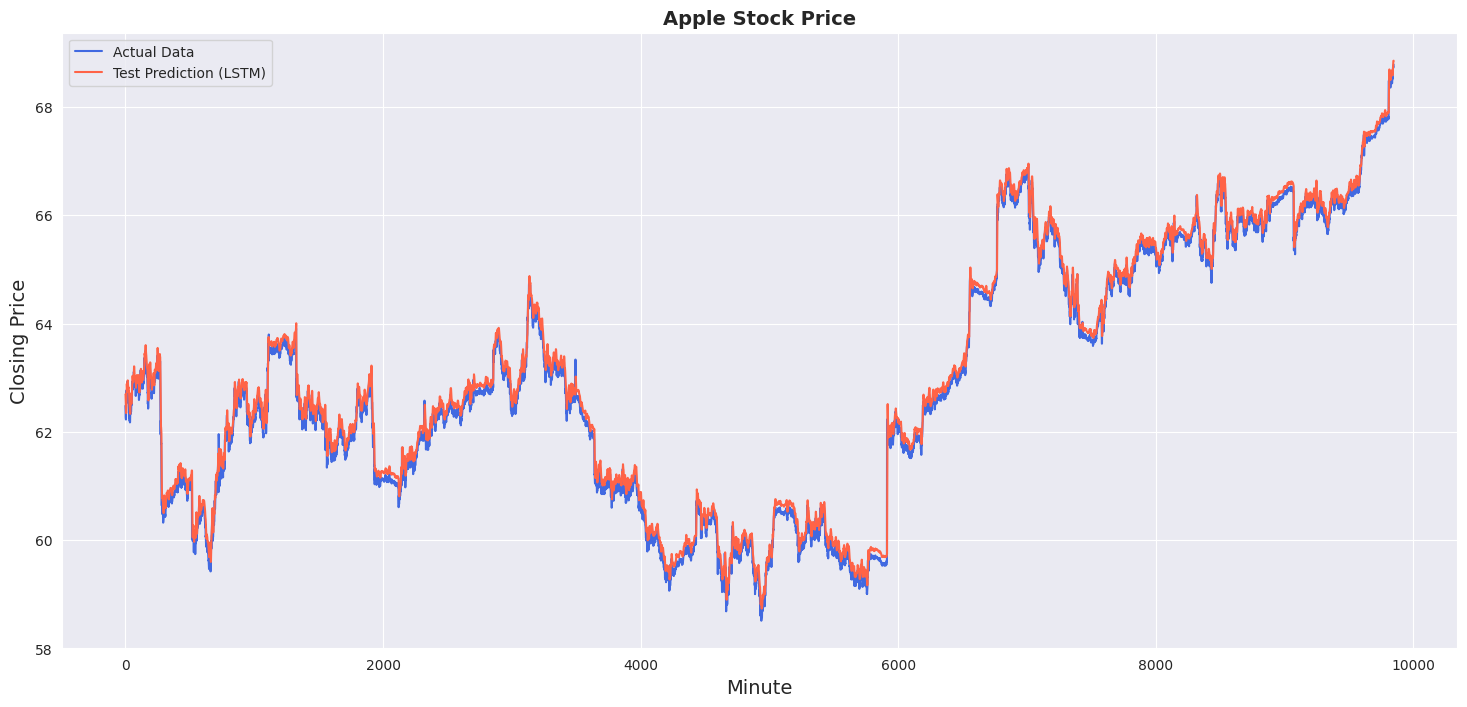

In [46]:
visualize_test_results(model, dataloader, "Apple Stock Price", "Closing Price")

### Class for Prediction Data Loader
- We will predict using the data trained on previous quarter for the next quarter

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class LSTMPredictDataLoader():

  def __init__(self, companies, start_timestamp, end_timestamp):
    self.companies = companies
    self.z_company_wise = {}
    self.z_price_scaler = StandardScaler()
    self.z_volume_scaler = StandardScaler()

    for i in companies:
      z_company_wise[i] = get_subset_of_dataset(i, start_date=start_timestamp, end_date=end_timestamp)
      z_company_wise[i].set_index('datetime', inplace=True)

    combined_data = pd.concat(list(z_company_wise.values()), axis=0, ignore_index=True)
    price_columns = ['open', 'high', 'low', 'close']
    volume_columns = ['volume']

    z_price_scaler.fit(combined_data[price_columns])
    z_volume_scaler.fit(combined_data[volume_columns])

    for i in companies:
      z_company_wise[i][['open', 'close', 'low', 'high']] = z_price_scaler.fit_transform(z_company_wise[i][['open', 'close', 'low', 'high']])
      z_company_wise[i]['volume'] = z_volume_scaler.fit_transform(z_company_wise[i][['volume']])


  def generate_dataset(self, company, other_companies_to_include = [], input_rows = ['close'], window_size=20):
    # first column name in input_rows should be the stock which we want to predict, generally close
    df = z_company_wise[company][input_rows]

    if len(other_companies_to_include) > 0:
      for comp in other_companies_to_include:
        new_df = z_company_wise[comp][input_rows]
        df = df.merge(new_df, how='inner', on='datetime')

    df_np = df.to_numpy()
    data = []

    for index in range(len(df_np) - window_size):
        data.append(df_np[index : index + window_size])

    data = np.array(data)

    x_value = data[:,:-1,:]
    y_value = data[:,-1,0].reshape(-1, 1)

    self.x_value = torch.from_numpy(x_value).type(torch.Tensor)
    self.y_value = torch.from_numpy(y_value).type(torch.Tensor)
    print("Dataloader Created Successfully")
    print("X : value_shape:",x_value.shape)
    print("Y : value_shape", y_value.shape)

In [48]:
from sklearn.metrics import mean_absolute_percentage_error

def predict_for_next_timeframe(predict_dataloader, model, minutes, title, ylabel):
  criterion = mean_absolute_percentage_error
  y_test_pred = model(predict_dataloader.x_value[ : minutes])
  y_test_pred_np = y_test_pred.detach().numpy()
  bv = np.ones((1, 4))
  y_tp_rshp = y_test_pred_np * bv

  y_test_og_np = predict_dataloader.y_value[ : minutes].detach().numpy()
  y_to_rshp = y_test_og_np * bv

  mape = criterion(y_test_pred.detach().numpy(), predict_dataloader.y_value[ : minutes].detach().numpy())

  print(f"Mean Absolute Percentage Error : {mape}")

  predict = pd.DataFrame(z_price_scaler.inverse_transform(y_tp_rshp))
  original = pd.DataFrame(z_price_scaler.inverse_transform(y_to_rshp))

  sns.set_style("darkgrid")

  fig = plt.figure(figsize=(20, 10))

  sns.lineplot(x = original[3].index, y = original[3], label="Actual Data", color='royalblue')
  sns.lineplot(x = predict[3].index, y = predict[3], label="Future Prediction (by LSTM)", color='tomato')
  plt.title(title, size = 14, fontweight='bold')
  plt.xlabel("Minutes into the Future", size = 14)
  plt.ylabel(ylabel, size = 14)

  fig.set_figheight(8)
  fig.set_figwidth(18)

  return mape

In [49]:
# get data for next quarter (next four month)
single_predict_dataloader = LSTMPredictDataLoader(['AAPL'], '2020-05-01 00:00:00', '2020-09-30 23:59:59')
single_predict_dataloader.generate_dataset('AAPL', window_size=25)

Dataloader Created Successfully
X : value_shape: (82226, 24, 1)
Y : value_shape (82226, 1)


## 6) Predicting Close Price for Single Company (AAPL) using all (Open, Close, High, Low, Volume)
- We will train the data on the data for a quarter (4 months) and predict it for the next quarter

In [50]:
input_dim = 5
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100
batch_size = 64

In [51]:
yr_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adagrad(yr_model.parameters(), lr=0.005)
yr_model

LSTM(
  (lstm): LSTM(5, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [52]:
dataloader = LSTMTrainDataLoader(['AAPL'], '2020-01-01 00:00:00', '2020-04-30 23:59:59')

In [55]:
dataloader.generate_dataset('AAPL', [], ['close', 'open', 'high', 'low', 'volume'], batch_size=batch_size, shuffle=True, window_size=25)

(65672, 5)
X : train_shape: (45953, 24, 5) test_shape: (9847, 24, 5) valid_shape: (9847, 24, 5)
Y : train_shape (45953, 1) test_shape: (9847, 1) valid_shape: (9847, 1)
Dataloader Created Successfully


In [56]:
hist = train_model(yr_model, num_epochs, dataloader, 10)

Epoch  0 Train MSE:  0.0009493078815948959 Validation MSE:  0.00013289522621372614 Time taken for Epoch: 7.013934373855591
Epoch  1 Train MSE:  0.0008770093335201049 Validation MSE:  6.690185393371279e-05 Time taken for Epoch: 4.921149015426636
Epoch  2 Train MSE:  0.0008335146613895727 Validation MSE:  6.968049533352365e-05 Time taken for Epoch: 4.944305181503296
Epoch  3 Train MSE:  0.0008071909110141242 Validation MSE:  6.431926064144998e-05 Time taken for Epoch: 4.906120300292969
Epoch  4 Train MSE:  0.0007806310547110644 Validation MSE:  6.742969166888351e-05 Time taken for Epoch: 4.026752233505249
Epoch  5 Train MSE:  0.0007575819201851477 Validation MSE:  6.759554575655936e-05 Time taken for Epoch: 4.076554298400879
Epoch  6 Train MSE:  0.0007398495420985836 Validation MSE:  9.520958774475062e-05 Time taken for Epoch: 5.0362913608551025
Epoch  7 Train MSE:  0.0007242613028916371 Validation MSE:  6.0613023100831446e-05 Time taken for Epoch: 4.839636325836182
Epoch  8 Train MSE:  

In [57]:
torch.save(yr_model, 'multiple_feature.pt')

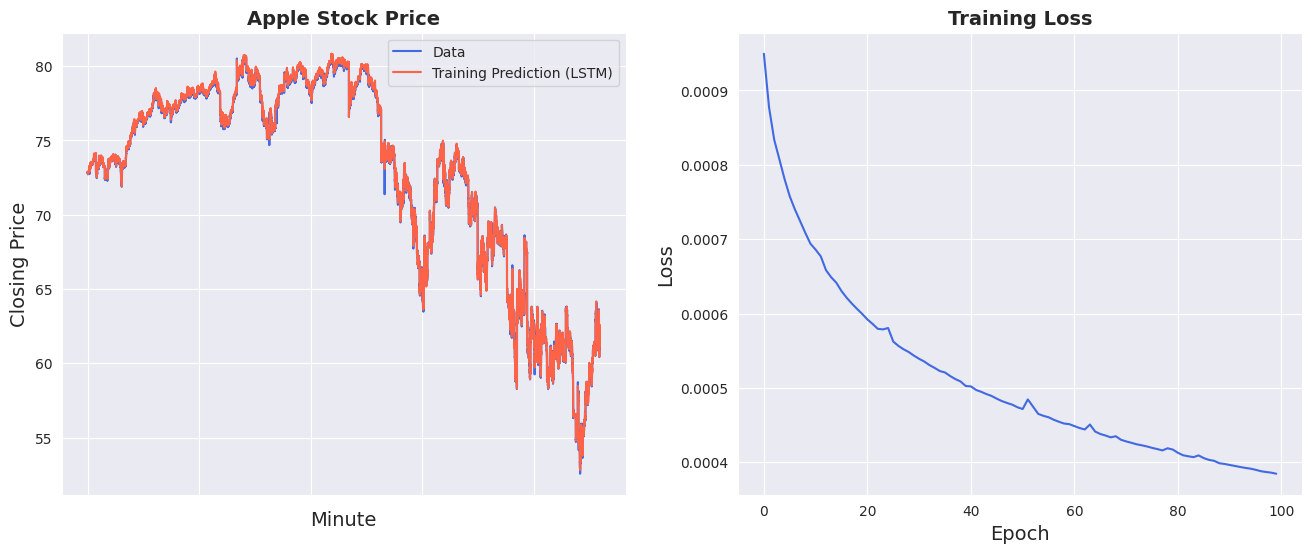

In [58]:
visualize_train_results(yr_model, dataloader, "Apple Stock Price", "Closing Price")

Testing MSE Loss : 0.00023274871637113392


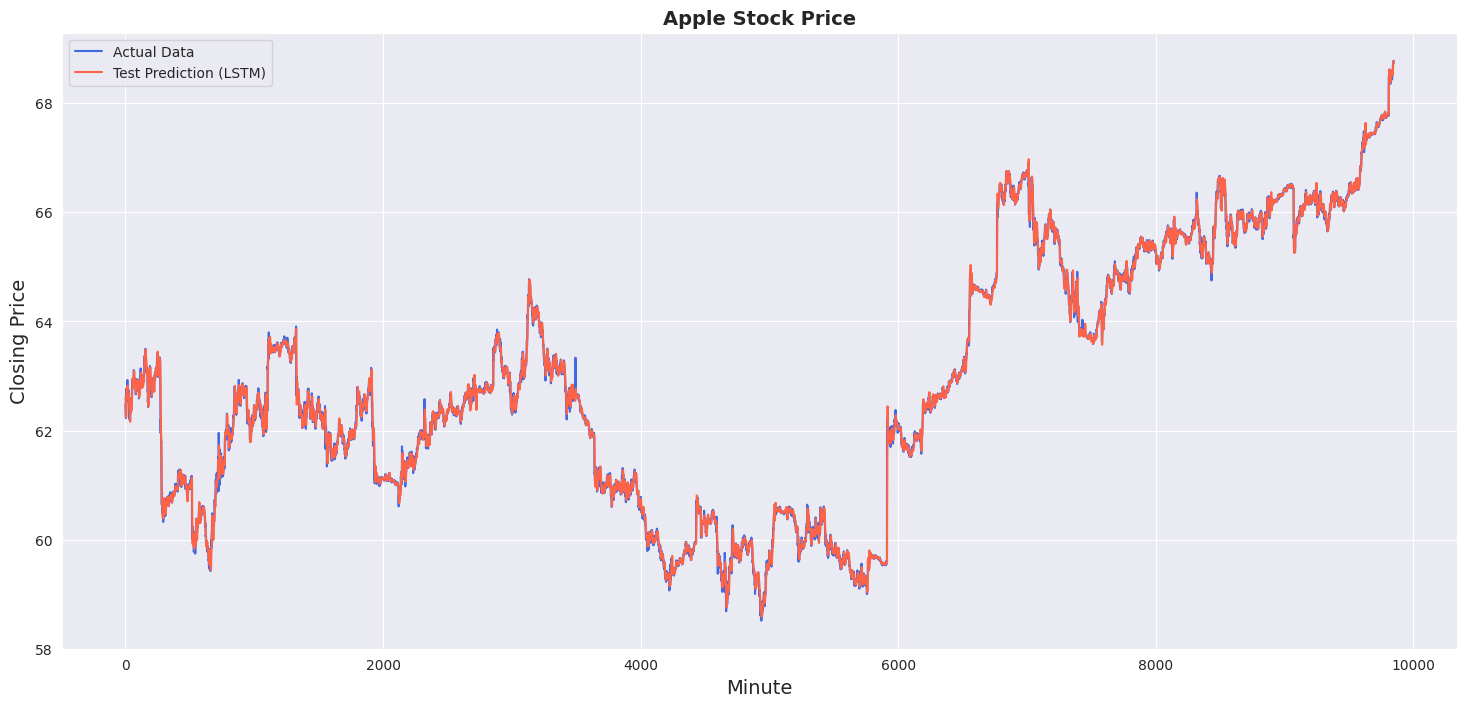

In [59]:
visualize_test_results(yr_model, dataloader, "Apple Stock Price", "Closing Price")

In [60]:
# get data for next quarter (next four month)
multiple_predict_dataloader = LSTMPredictDataLoader(['AAPL'], '2020-05-01 00:00:00', '2020-09-30 23:59:59')
multiple_predict_dataloader.generate_dataset('AAPL', [], input_rows=['close', 'open', 'high', 'low', 'volume'], window_size=25)

Dataloader Created Successfully
X : value_shape: (82226, 24, 5)
Y : value_shape (82226, 1)


### Future Predictions for Single Column Input

Mean Absolute Percentage Error : 0.012416358105838299
Mean Absolute Percentage Error : 0.012076830491423607
Mean Absolute Percentage Error : 0.012932810932397842
Mean Absolute Percentage Error : 0.013008462265133858
Mean Absolute Percentage Error : 0.014829764142632484
Mean Absolute Percentage Error : 0.016367249190807343
Mean Absolute Percentage Error : 0.04792880639433861
Mean Absolute Percentage Error : 0.032405443489551544


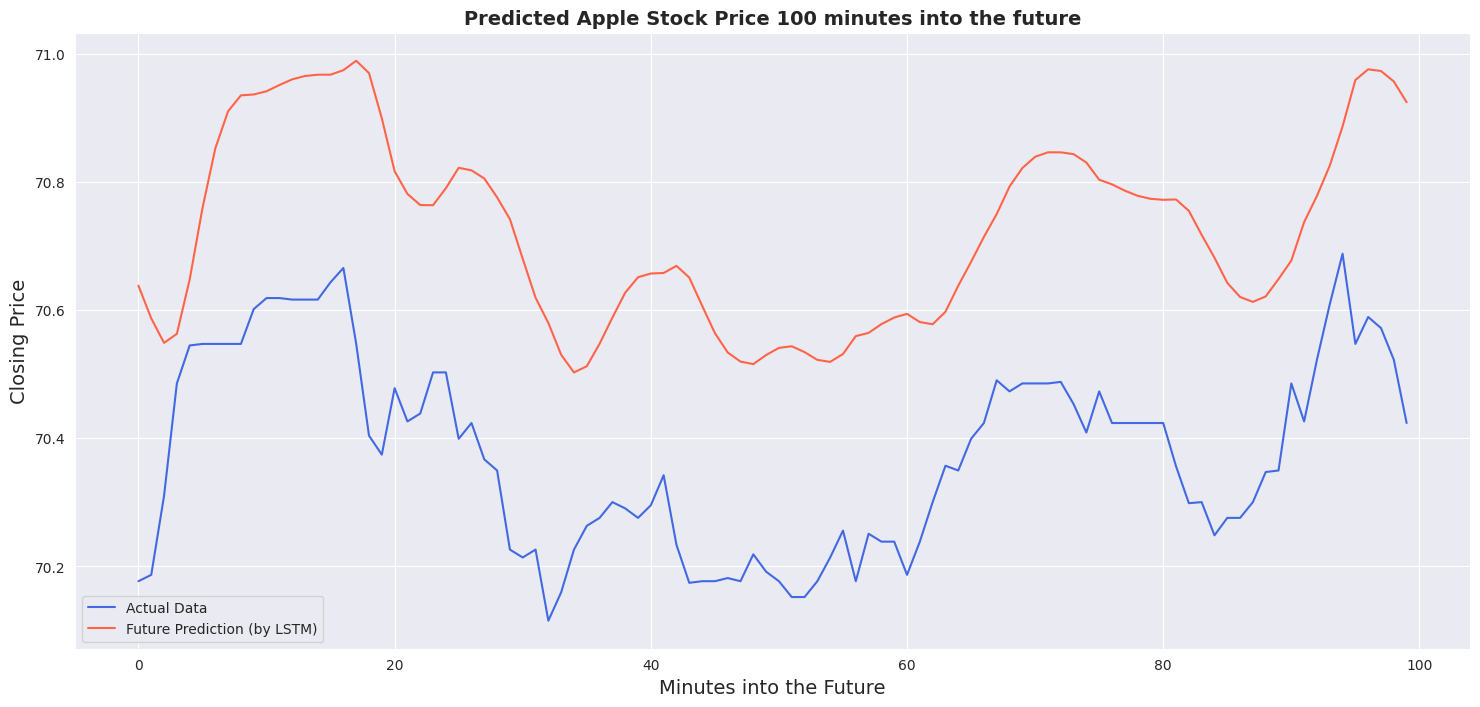

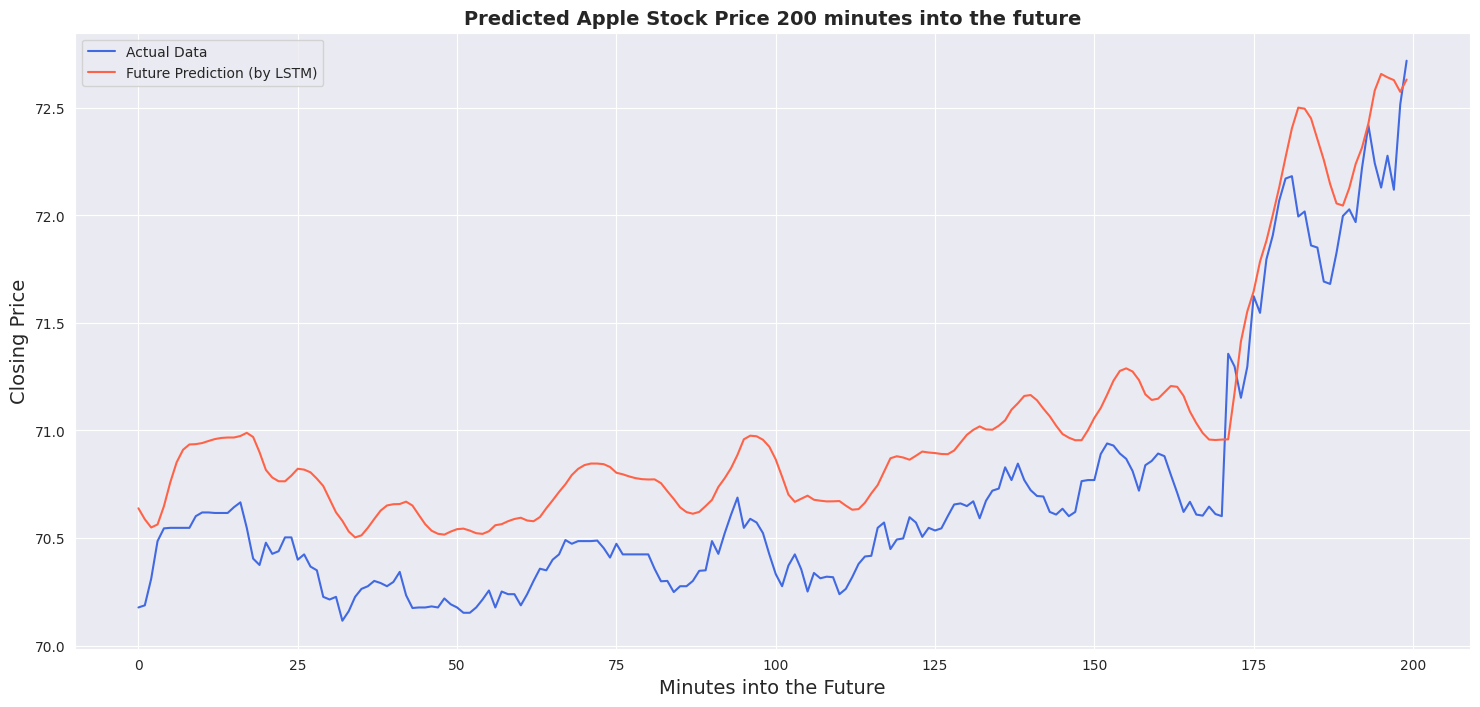

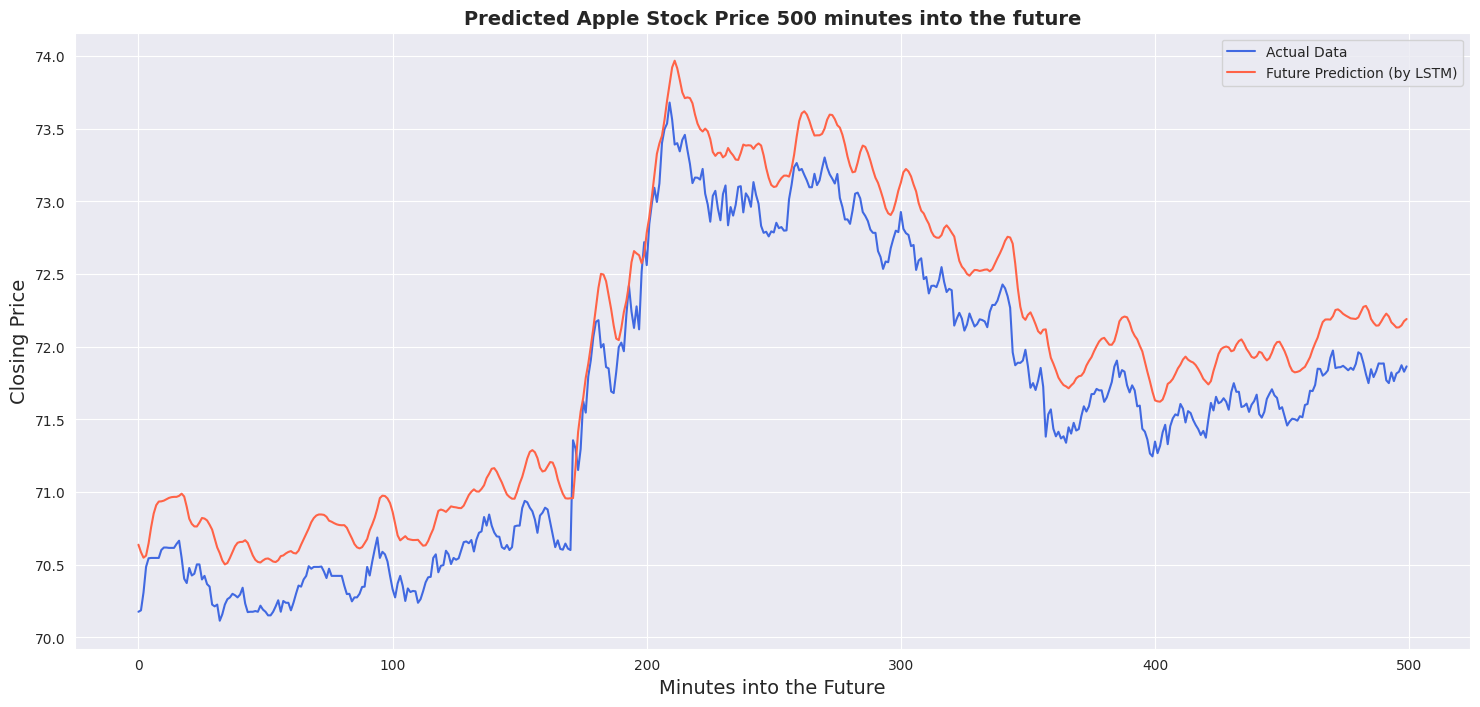

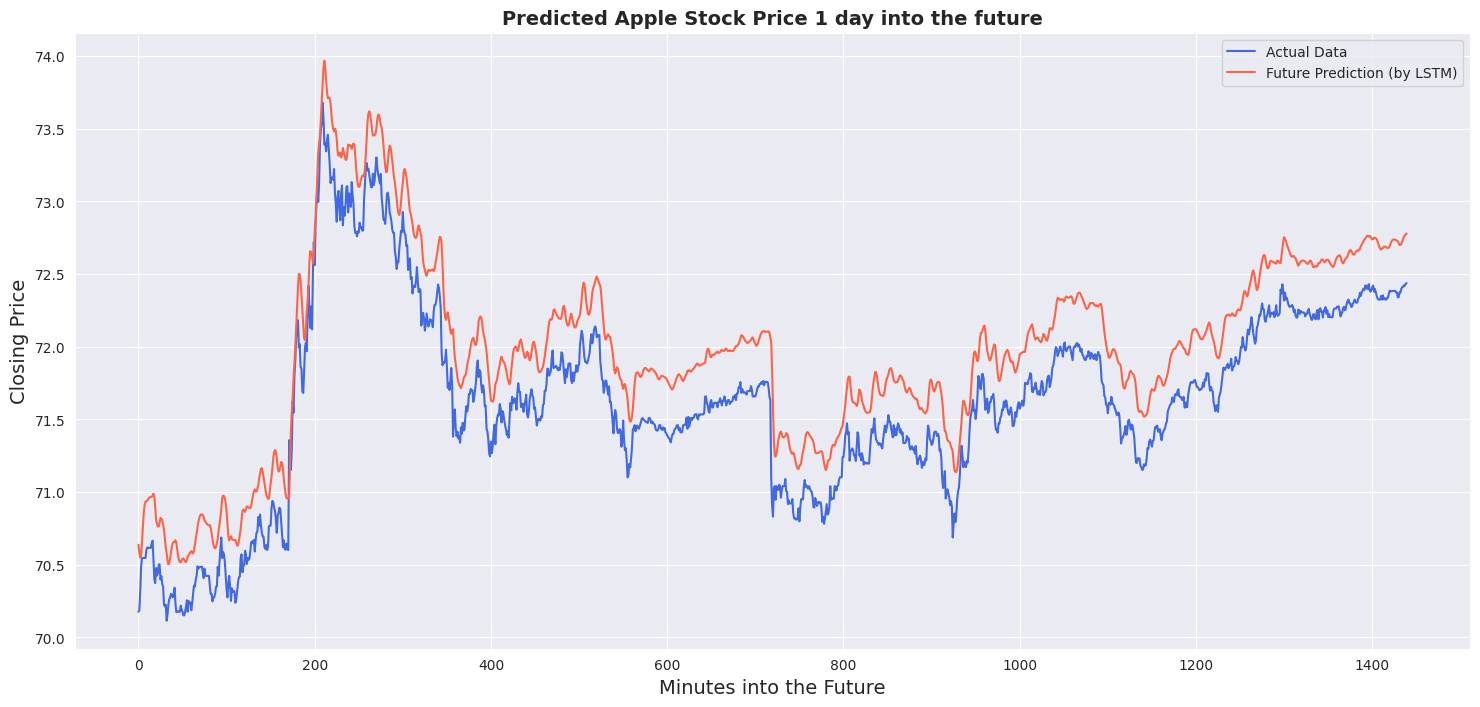

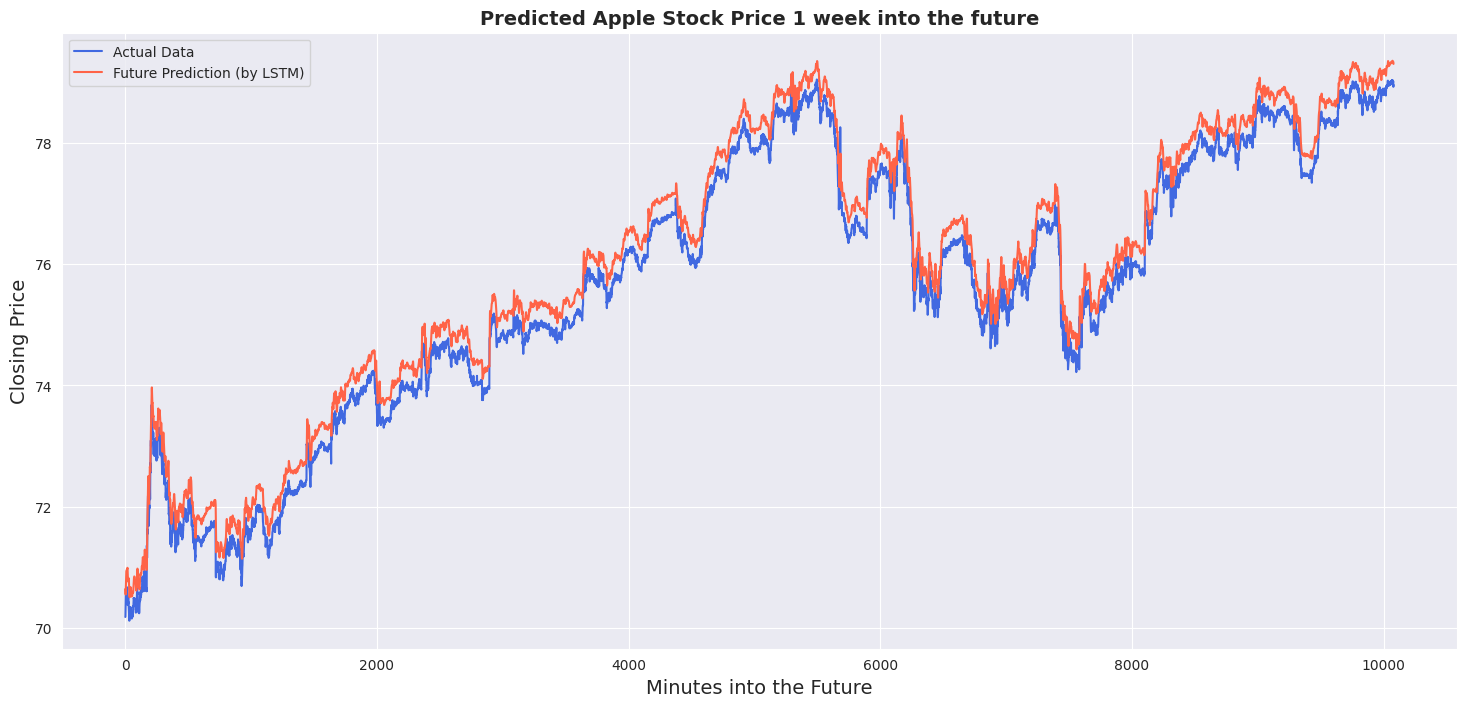

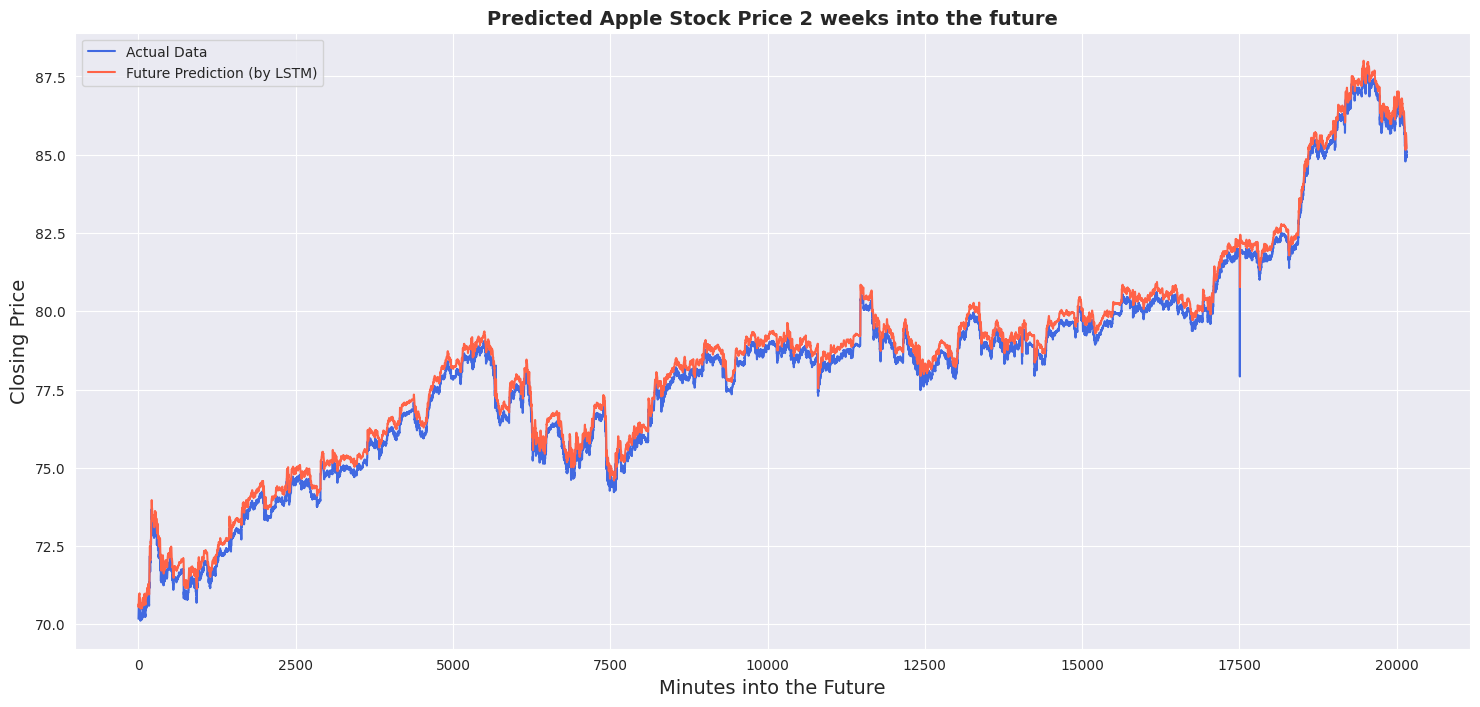

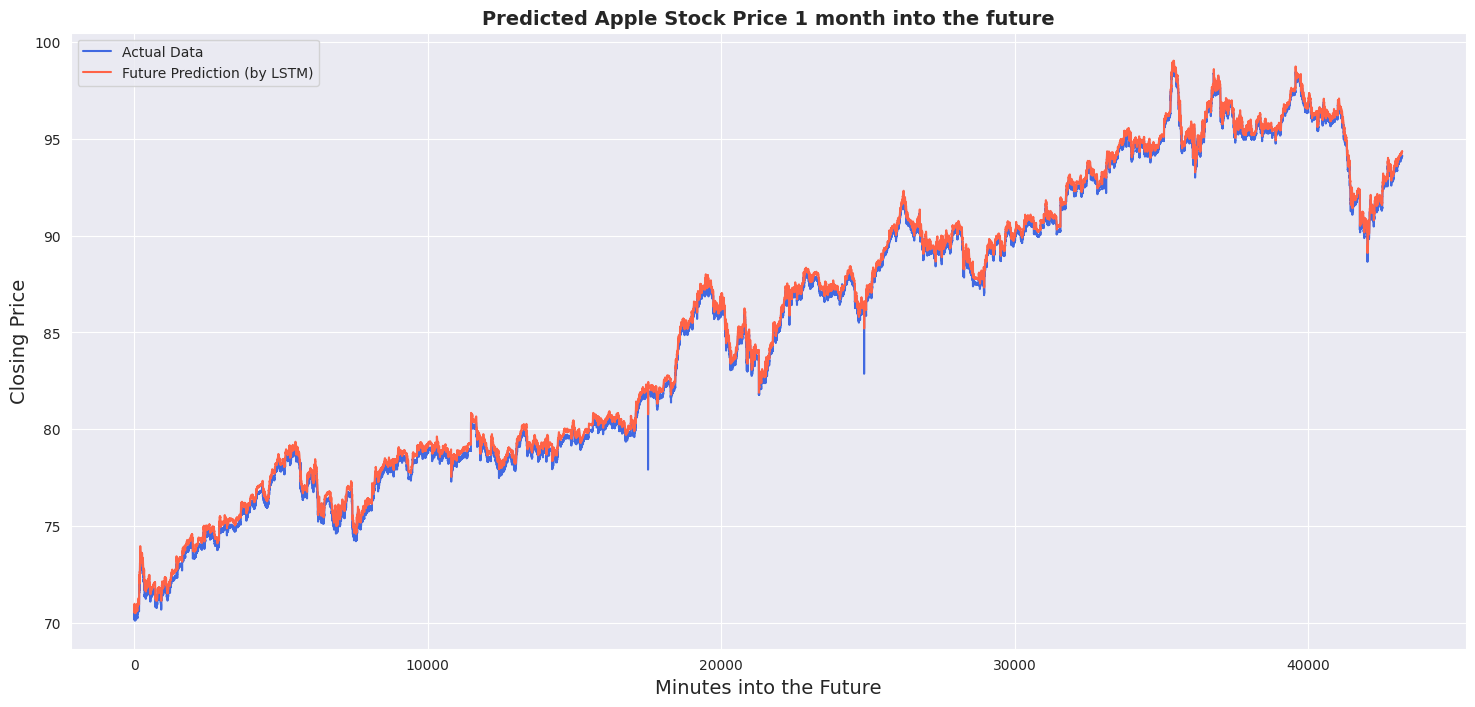

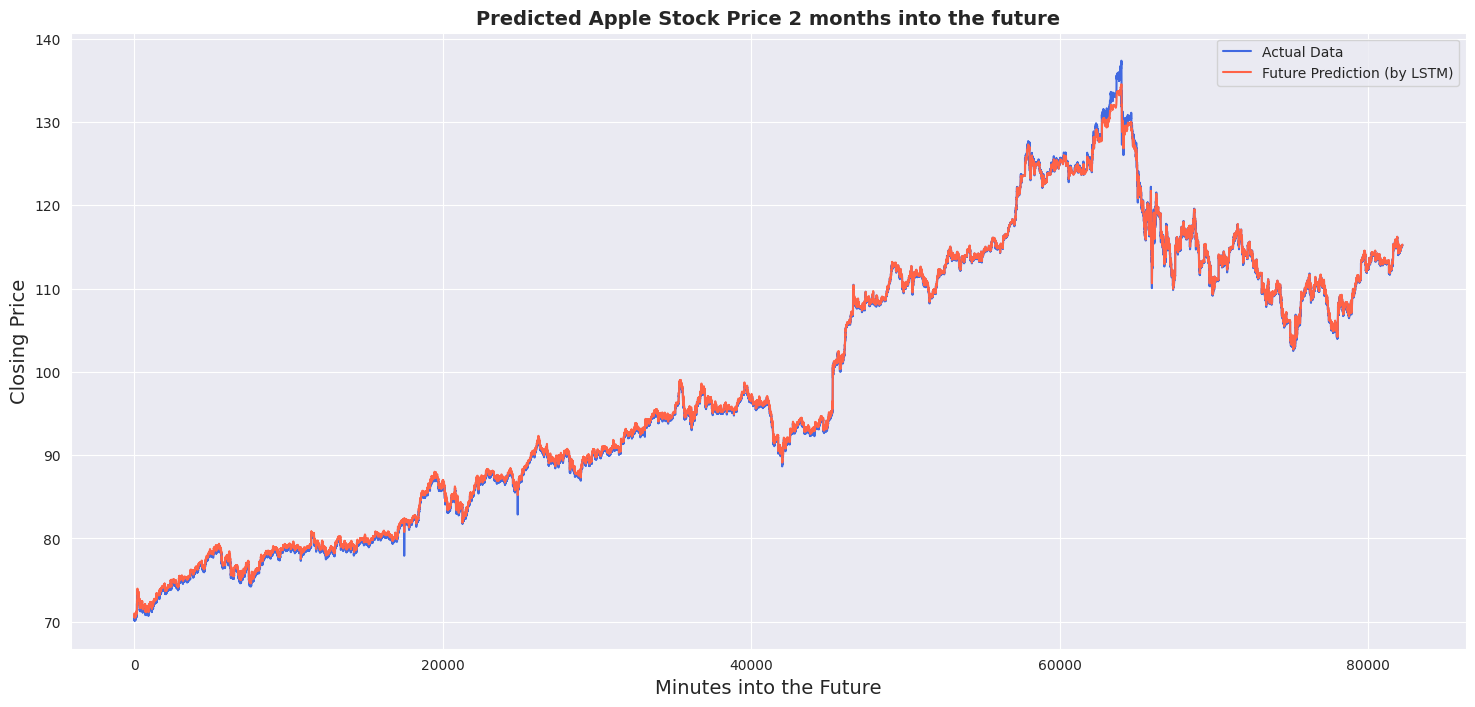

In [61]:
times = [100, 200, 500, 24*60, 7*24*60, 14*24*60, 30*24*60, 60*24*60]
headers = ['100 minutes', '200 minutes', '500 minutes', '1 day', '1 week', '2 weeks', '1 month', '2 months']
single_mape_vec = []
for j, i in enumerate(times):
  single_mape_vec.append(float(predict_for_next_timeframe(single_predict_dataloader, model, i, f"Predicted Apple Stock Price {headers[j]} into the future", "Closing Price")))

### Future Predictions for Multiple Column Input

Mean Absolute Percentage Error : 0.002274617552757263
Mean Absolute Percentage Error : 0.0036712568253278732
Mean Absolute Percentage Error : 0.003638570662587881
Mean Absolute Percentage Error : 0.002601273823529482
Mean Absolute Percentage Error : 0.0024992458056658506
Mean Absolute Percentage Error : 0.0028496410232037306
Mean Absolute Percentage Error : 0.01349552720785141
Mean Absolute Percentage Error : 0.014390585012733936


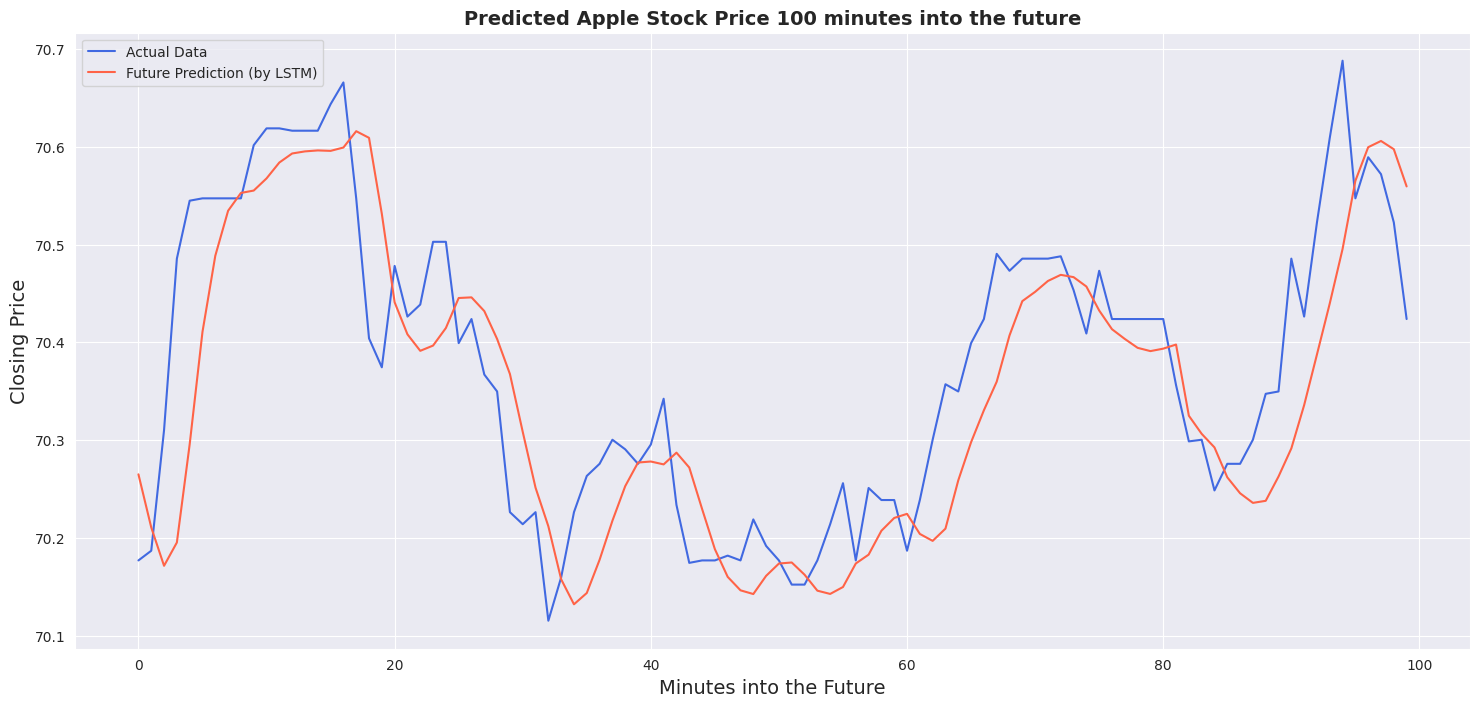

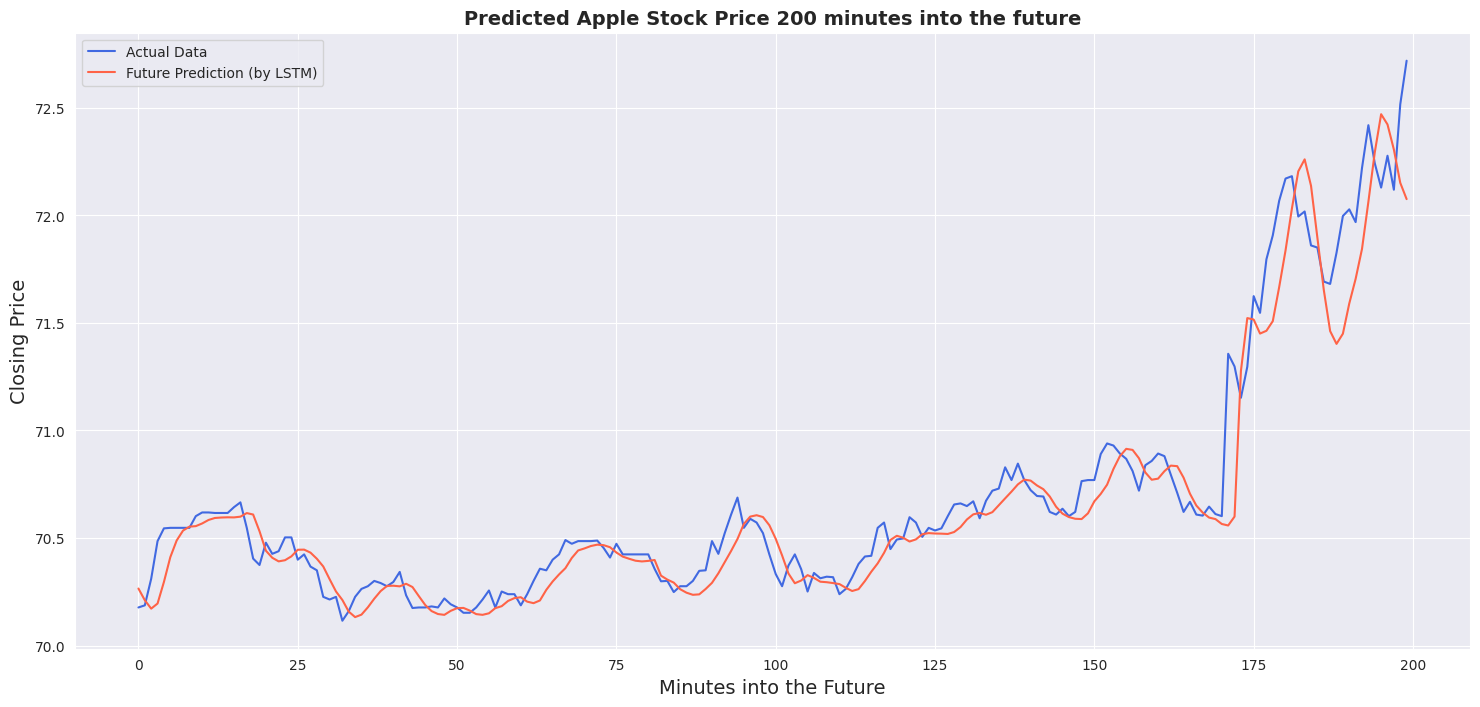

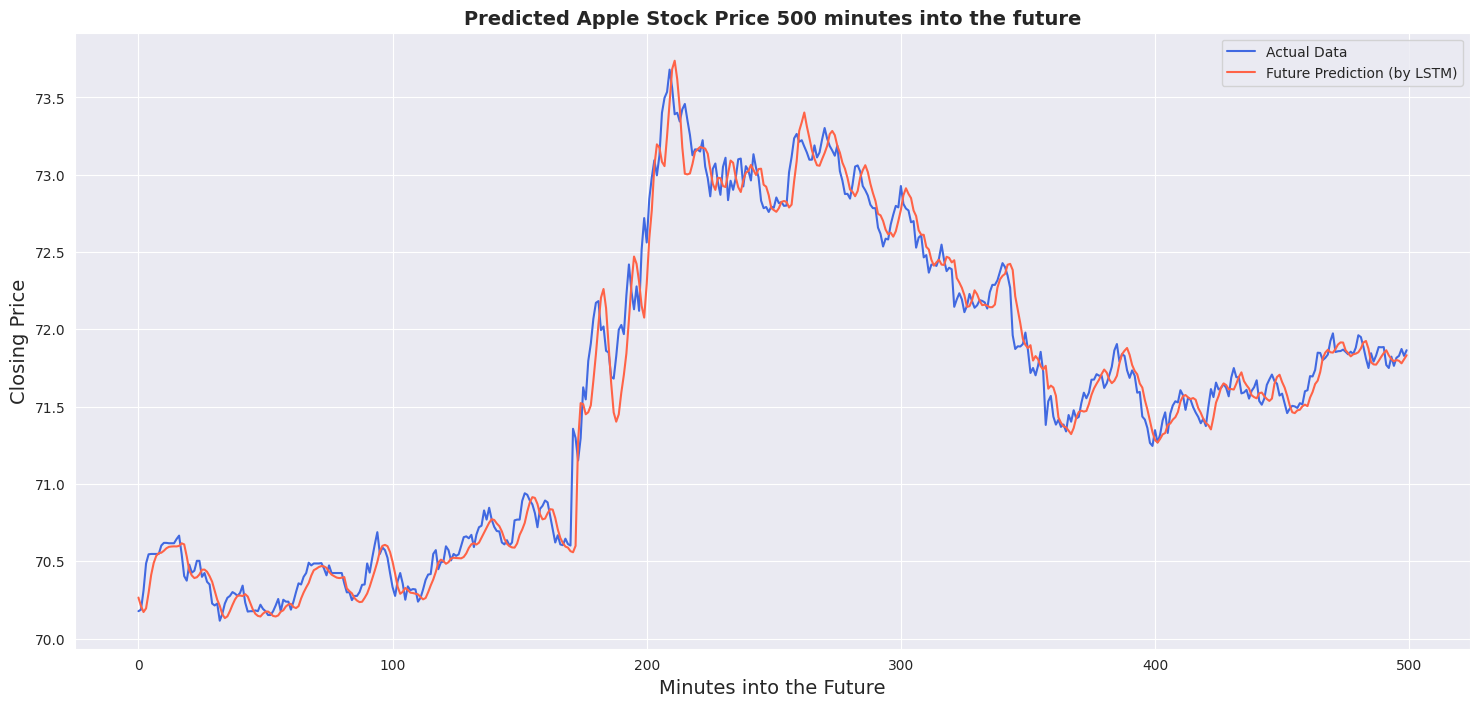

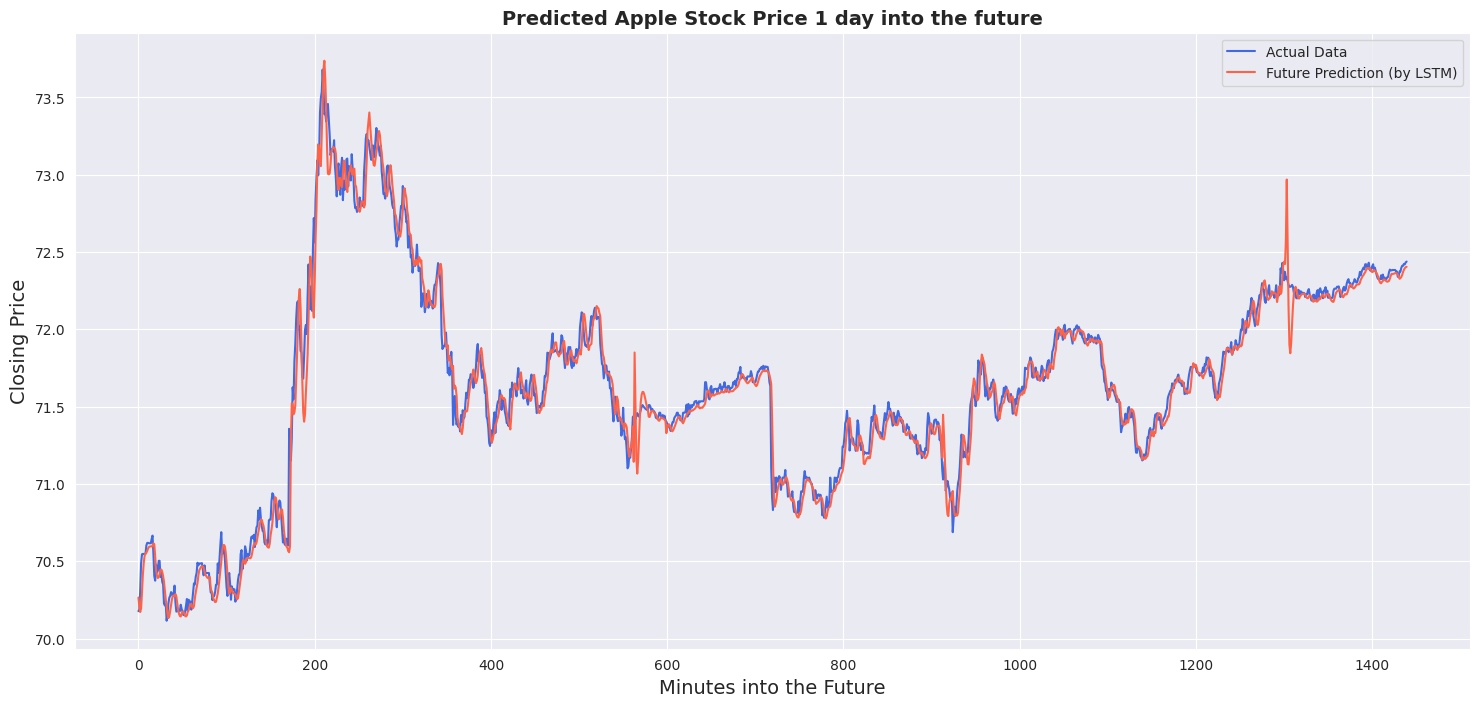

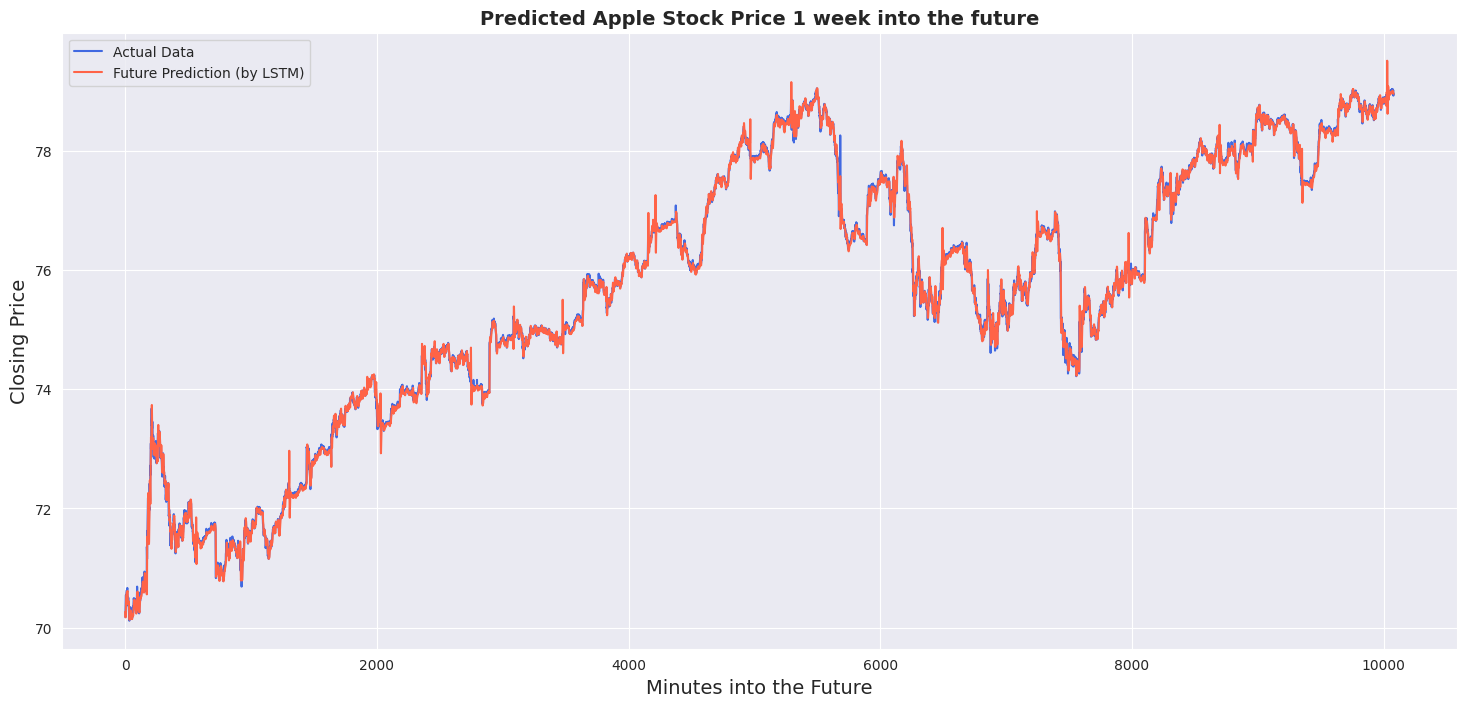

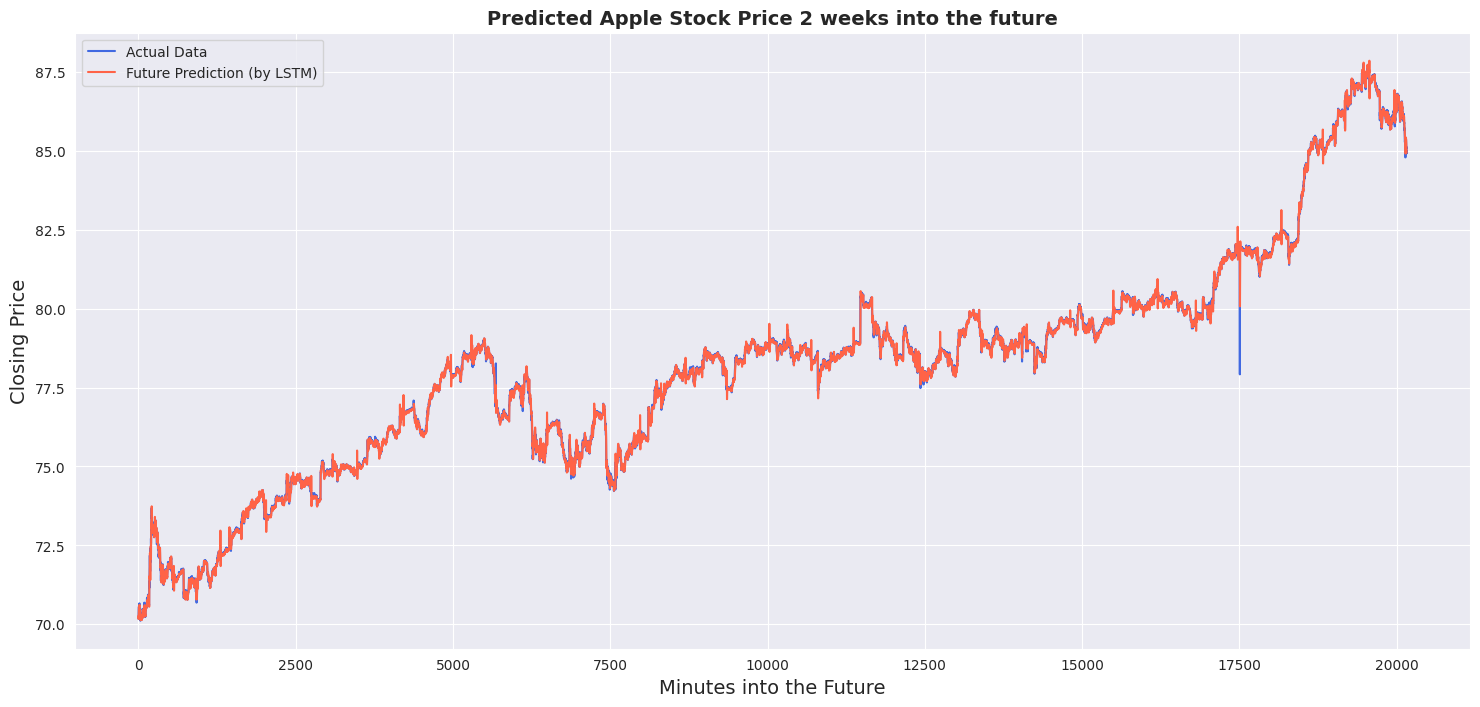

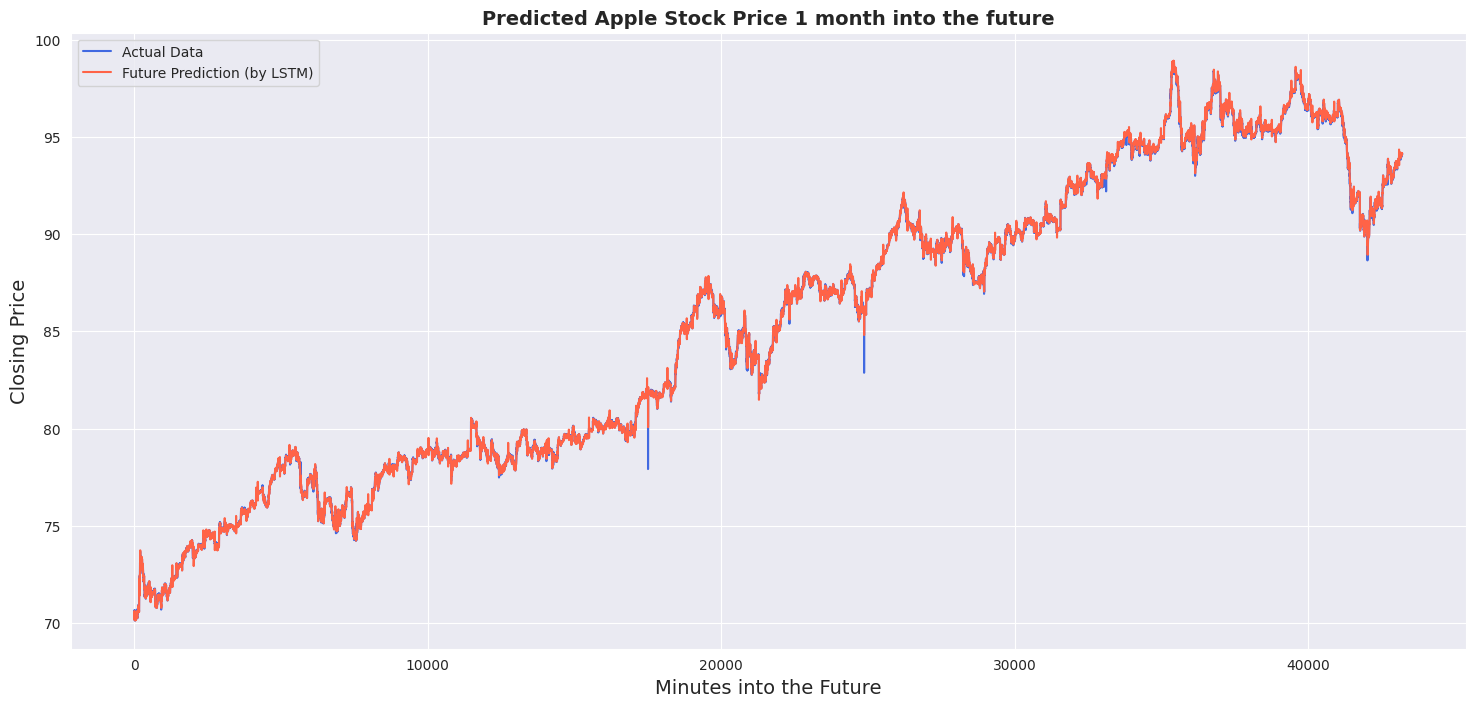

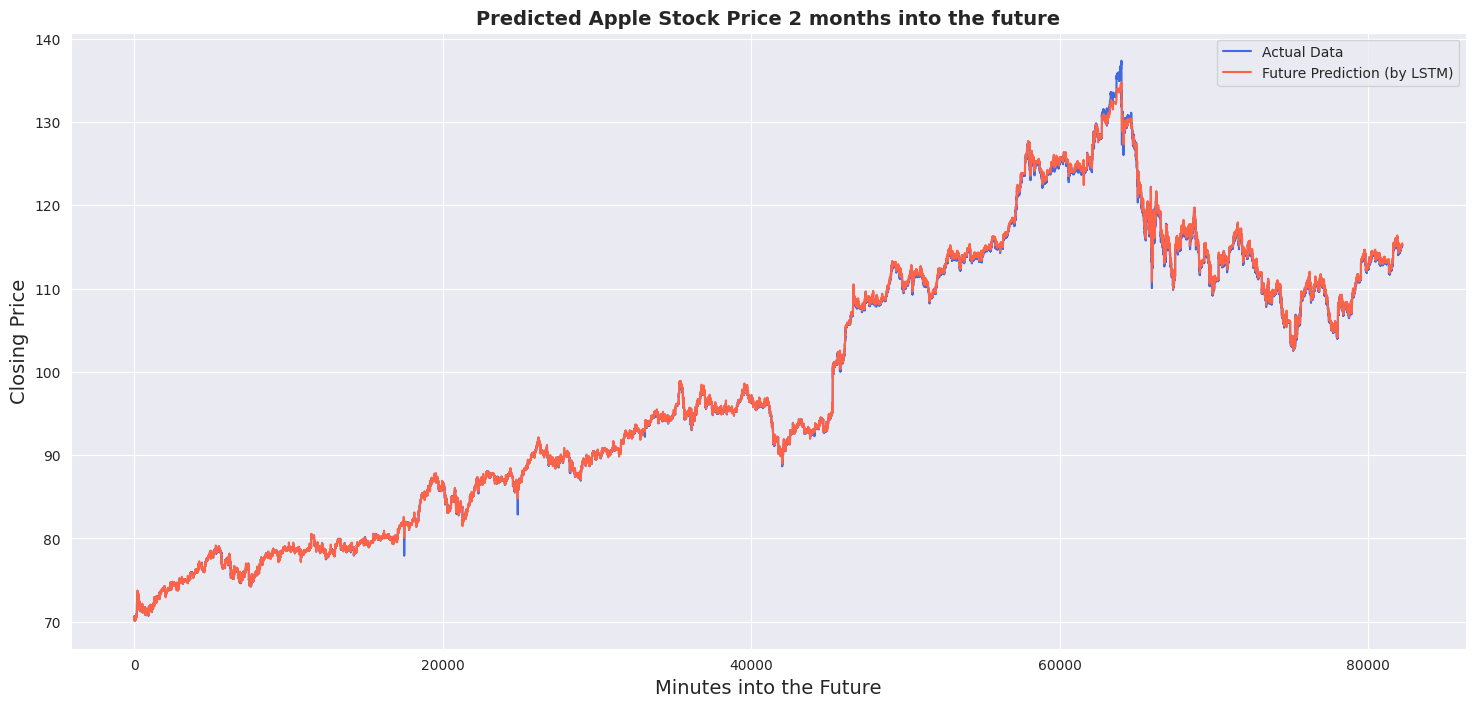

In [62]:
times = [100, 200, 500, 24*60, 7*24*60, 14*24*60, 30*24*60, 60*24*60]
headers = ['100 minutes', '200 minutes', '500 minutes', '1 day', '1 week', '2 weeks', '1 month', '2 months']
multiple_mape_vec = []
for j, i in enumerate(times):
  multiple_mape_vec.append(float(predict_for_next_timeframe(multiple_predict_dataloader, yr_model, i, f"Predicted Apple Stock Price {headers[j]} into the future", "Closing Price")))

## 7) Trading Module

In [136]:
class AlgorithmicTrader():

  def __init__(self, lstm, initial_money, commission_per_trade, buy_ask_spread):
    self.lstm = lstm
    self.curr_money = initial_money
    self.commission_per_trade = commission_per_trade
    self.buy_ask_spread = buy_ask_spread
    self.curr_minute = 0
    self.number_of_stocks = 0

  def get_net_worth(self, price):
    return self.curr_money + (price * self.number_of_stocks)

  def buy(self, num_of_stocks, price, debug):
    if(self.curr_money >= price*num_of_stocks + self.commission_per_trade and self.curr_money != 0):
      self.number_of_stocks += num_of_stocks
      self.curr_money -= (price*num_of_stocks)
      self.curr_money -= self.commission_per_trade
      if debug:
        print(f"Bought : {num_of_stocks} stocks")
    else:
      if debug:
        print("Holding : Did nothing")

  def sell(self, num_of_stocks, price, debug):
    if(self.number_of_stocks >= num_of_stocks and self.number_of_stocks != 0):
      self.number_of_stocks -= num_of_stocks
      self.curr_money += (price*num_of_stocks)
      self.curr_money -= self.commission_per_trade
      if debug:
        print(f"Sold : {num_of_stocks} stocks")
    else:
      if debug:
        print("Holding : Did nothing")

  def get_max_stocks_buyable(self, price):
    stocks = 0
    while(price*stocks + self.commission_per_trade <= self.curr_money):
      stocks += 1
    return stocks - 1

  def reinitialize_after_training(self):
    self.curr_minute = 0

  def trade(self, predict_dataloader, trade_after, max_interval, normal_trade_stocks, min_profit_threshold, max_profit_threshold, debug=False):
    start_time = self.curr_minute
    global_max = 0
    curr_iter = 0
    while (self.curr_minute - start_time) < max_interval:
      predict_minute = self.curr_minute + trade_after
      y_test_pred = self.lstm(predict_dataloader.x_value[predict_minute : predict_minute + 1])
      y_test_pred_np = y_test_pred.detach().numpy()
      bv = np.ones((1, 4))
      y_tp_rshp = y_test_pred_np * bv

      y_test_og_np = predict_dataloader.y_value[predict_minute : predict_minute + 1].detach().numpy()
      y_to_rshp = y_test_og_np * bv

      prediction = z_price_scaler.inverse_transform(y_tp_rshp)[0][3]
      current_price = predict_dataloader.y_value[self.curr_minute : self.curr_minute + 1]
      current_price = current_price.detach().numpy()
      bv = np.ones((1, 4))
      current_price = current_price * bv
      current_price = z_price_scaler.inverse_transform(current_price)[0][3]
      global_max = max(global_max, current_price)

      pred_profit = (prediction - (current_price + self.buy_ask_spread)) * normal_trade_stocks - self.commission_per_trade

      if curr_iter == 0:
         print("Start Net Worth: ", self.get_net_worth(current_price))

      if debug:
        print("---------------------------------------")
        print(f"Current minute {self.curr_minute}")
        print(f"Global maximal price", global_max)
        print("Current price :", current_price)
        print("Current money :", self.curr_money)
        print("Current stocks :", self.number_of_stocks)
        print(f"Net Worth :", self.get_net_worth(current_price))
        print("Predicted Price :", prediction)
        print("Predicted Profit :", pred_profit)
        print("---------------------------------------\n\n")

      if(pred_profit >= max_profit_threshold and prediction > global_max):
        if debug:
          print("Did First Option")
        self.buy(self.get_max_stocks_buyable(current_price + self.buy_ask_spread), current_price + self.buy_ask_spread, debug)
      elif(pred_profit >= min_profit_threshold and prediction > global_max):
        if debug:
          print("Did Second Option")
        self.buy(normal_trade_stocks, current_price + self.buy_ask_spread, debug)
      elif(pred_profit > - min_profit_threshold and prediction > global_max):
        if debug:
          print("Did Third Option")
        self.sell(self.number_of_stocks, current_price - self.buy_ask_spread, debug)
      elif(pred_profit > - max_profit_threshold and prediction > global_max):
        if debug:
          print("Did Fourth Option")
        self.sell(self.number_of_stocks, current_price - self.buy_ask_spread, debug)
      else:
        if debug:
          print("Did Last Option")
        self.sell(self.number_of_stocks, current_price - self.buy_ask_spread, debug)

      self.curr_minute = self.curr_minute + trade_after
      curr_iter += 1
    print("End Net Worth: ", self.get_net_worth(current_price))

In [137]:
class BuyAndHoldTrader():

  def __init__(self, initial_money, commission_per_trade, buy_ask_spread):
    self.curr_money = initial_money
    self.commission_per_trade = commission_per_trade
    self.buy_ask_spread = buy_ask_spread
    self.curr_minute = 0
    self.number_of_stocks = 0

  def get_net_worth(self, price):
    return self.curr_money + (price * self.number_of_stocks)

  def buy(self, num_of_stocks, price, debug):
    if(self.curr_money >= price*num_of_stocks + self.commission_per_trade and self.curr_money != 0):
      self.number_of_stocks += num_of_stocks
      self.curr_money -= (price*num_of_stocks)
      self.curr_money -= self.commission_per_trade
      if debug:
        print(f"Bought : {num_of_stocks} stocks")
    else:
      if debug:
        print("Holding : Did nothing")

  def sell(self, num_of_stocks, price, debug):
    if(self.number_of_stocks >= num_of_stocks and self.number_of_stocks != 0):
      self.number_of_stocks -= num_of_stocks
      self.curr_money += (price*num_of_stocks)
      self.curr_money -= self.commission_per_trade
      if debug:
        print(f"Sold : {num_of_stocks} stocks")
    else:
      if debug:
        print("Holding : Did nothing")

  def get_max_stocks_buyable(self, price):
    stocks = 0
    while(price*stocks + self.commission_per_trade <= self.curr_money):
      stocks += 1
    return stocks - 1

  def trade(self, predict_dataloader, max_interval, debug=False):
    sell_minute = self.curr_minute + max_interval
    bv = np.ones((1, 4))
    y_test_og_np = predict_dataloader.y_value[sell_minute : sell_minute + 1].detach().numpy()
    y_to_rshp = y_test_og_np * bv

    sell_price = z_price_scaler.inverse_transform(y_to_rshp)[0][3]
    current_price = predict_dataloader.y_value[self.curr_minute : self.curr_minute + 1]
    current_price = current_price.detach().numpy()
    bv = np.ones((1, 4))
    current_price = current_price * bv
    current_price = z_price_scaler.inverse_transform(current_price)[0][3]

    print("Start Net Worth: ", self.get_net_worth(current_price))
    self.buy(self.get_max_stocks_buyable(current_price + self.buy_ask_spread), current_price + self.buy_ask_spread, debug)
    self.sell(self.number_of_stocks, sell_price - self.buy_ask_spread, debug)
    print("End Net Worth: ", self.get_net_worth(sell_price))

    self.curr_minute = sell_minute

### With no commission and buy-ask spread

### The Single Input Feature LSTM

In [201]:
algo_trader = AlgorithmicTrader(model, 10000, 0, 0)

In [202]:
algo_trader.trade(single_predict_dataloader, 10, 1*24*60, 5, 0.3, 0.5, False)

Start Net Worth:  10000.0
End Net Worth:  10216.059127682567


### The Multiple Input Feature LSTM

In [203]:
algo_trader_m = AlgorithmicTrader(yr_model, 10000, 0, 0)

In [204]:
algo_trader_m.trade(multiple_predict_dataloader, 10, 1*24*60, 5, 0.3, 0.5, False)

Start Net Worth:  10000.0
End Net Worth:  10195.287275885245


### Simple Buy and Hold Strategy

In [205]:
normal_trader = BuyAndHoldTrader(10000, 0, 0)

In [206]:
normal_trader.trade(single_predict_dataloader, 1*24*60, True)

Start Net Worth:  10000.0
Bought : 74 stocks
Sold : 74 stocks
End Net Worth:  10124.366819644707


### With commission and buy-ask spread

Assuming that the commission per trade is 1 USD and the buy ask spread is 5 cents (average values used for high frequency trading in NYSE as per the internet) as discussed above in Q3

### The Single Input Feature LSTM

In [199]:
algo_trader = AlgorithmicTrader(model, 10000, 1, 0.05)

In [200]:
algo_trader.trade(single_predict_dataloader, 10, 1*24*60, 5, 0.3, 0.5, False)

Start Net Worth:  10000.0
End Net Worth:  10185.850360461822


### The Multiple Input Feature LSTM

In [207]:
algo_trader_m = AlgorithmicTrader(yr_model, 10000, 1, 0.05)

In [208]:
algo_trader_m.trade(multiple_predict_dataloader, 10, 1*24*60, 5, 0.3, 0.5, False)

Start Net Worth:  10000.0
End Net Worth:  10122.584016377996


### Simple Buy and Hold Strategy

In [211]:
normal_trader = BuyAndHoldTrader(10000, 1, 0.05)

In [212]:
normal_trader.trade(single_predict_dataloader, 1*24*60, True)

Start Net Worth:  10000.0
Bought : 74 stocks
Sold : 74 stocks
End Net Worth:  10114.966819644706


## 8) Testing the Trading Module

### 8a) Plotting Prediction Error from time last trained

### Prediction comparison for single input vs multiple inputs to the LSTM

In [77]:
def visualize_mape(headers, *mape_vecs):

    plt.figure(figsize=(12, 5))
    plt.bar(headers, mape_vecs[0], label='single input (close)', color='blue', alpha=0.7)
    plt.bar(headers, mape_vecs[1], label='multiple input (close, open, high, low, volume)', color='red', alpha=0.7)

    # Adding labels and title
    plt.xlabel('Minutes into the Future')
    plt.ylabel('Price Prediction Error (MAPE)')
    plt.title('Comparison of Single Stock Input vs Multiple Inputs')
    plt.legend()

    # Adjusting the layout for better visibility
    plt.tight_layout()

    # Show the plot
    plt.show()

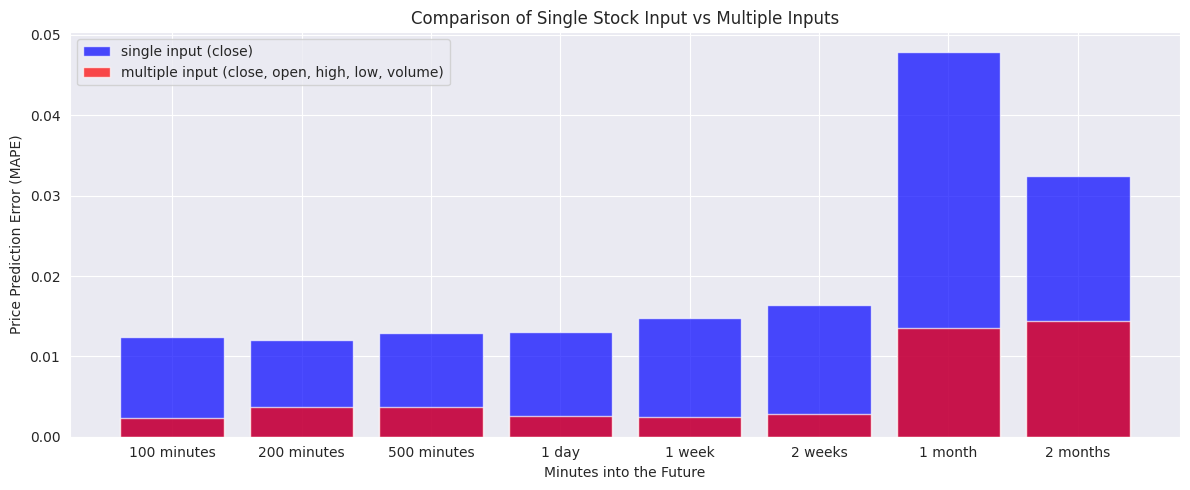

In [78]:
visualize_mape(headers, single_mape_vec, multiple_mape_vec)

Thus we see that the prediction error is less when we include more number of inputs, and the LSTM performs better and have lesser MAPE for more inputs

We see that the error is minimal for short durations of time (upto 1-2 weeks), but becomes progressively larger as the time duration increases upto a month and so on

### To test the training module on a long duration on later years we shall follow the following strategy. We will perform the test for a duration of one year (2021)

- The buy and hold trader will just buy maximum possible stocks, wait for one year and sell the stocks

- We saw from the MAPEs evaluated that LSTM starts to perform poorly as the timeframe exceeds more 2 months, hence we shall perform retraining on the passed quarter once every 4 months

- To maximize retention of stock price knowledge, algorithmic trader will train on every four months data and predict for the next 4 months and use the LSTM to predict prices



### Buy and Hold Trader

In [213]:
# get data for next year
bh_predict_dataloader = LSTMPredictDataLoader(['AAPL'], '2021-01-01 00:00:00', '2022-01-31 23:59:59')
bh_predict_dataloader.generate_dataset('AAPL', window_size=25)

Dataloader Created Successfully
X : value_shape: (224358, 24, 1)
Y : value_shape (224358, 1)


In [214]:
normal_trader = BuyAndHoldTrader(10000, 0, 0)
normal_trader.trade(bh_predict_dataloader, 224357, True)

Start Net Worth:  10000.0
Bought : 75 stocks
Sold : 75 stocks
End Net Worth:  13091.880530932862


In [215]:
cnormal_trader = BuyAndHoldTrader(10000, 1, 0.05)
cnormal_trader.trade(bh_predict_dataloader, 224357, True)

Start Net Worth:  10000.0
Bought : 75 stocks
Sold : 75 stocks
End Net Worth:  13082.380530932858


### Algorithmic Trader

In [216]:
# get training dataloaders in quarters
at_dataloader_1 = LSTMTrainDataLoader(['AAPL'], '2020-09-01 00:00:00', '2020-12-31 23:59:59')
at_dataloader_1.generate_dataset('AAPL', [], ['close', 'open', 'high', 'low', 'volume'], batch_size=batch_size, shuffle=True, window_size=25)
at_dataloader_2 = LSTMTrainDataLoader(['AAPL'], '2021-01-01 00:00:00', '2021-04-30 23:59:59')
at_dataloader_2.generate_dataset('AAPL', [], ['close', 'open', 'high', 'low', 'volume'], batch_size=batch_size, shuffle=True, window_size=25)
at_dataloader_3 = LSTMTrainDataLoader(['AAPL'], '2021-05-01 00:00:00', '2021-08-30 23:59:59')
at_dataloader_3.generate_dataset('AAPL', [], ['close', 'open', 'high', 'low', 'volume'], batch_size=batch_size, shuffle=True, window_size=25)

(75142, 5)
X : train_shape: (52581, 24, 5) test_shape: (11268, 24, 5) valid_shape: (11268, 24, 5)
Y : train_shape (52581, 1) test_shape: (11268, 1) valid_shape: (11268, 1)
Dataloader Created Successfully
(71207, 5)
X : train_shape: (49828, 24, 5) test_shape: (10677, 24, 5) valid_shape: (10677, 24, 5)
Y : train_shape (49828, 1) test_shape: (10677, 1) valid_shape: (10677, 1)
Dataloader Created Successfully
(66342, 5)
X : train_shape: (46421, 24, 5) test_shape: (9948, 24, 5) valid_shape: (9948, 24, 5)
Y : train_shape (46421, 1) test_shape: (9948, 1) valid_shape: (9948, 1)
Dataloader Created Successfully


In [217]:
at_predict_dataloader_1 = LSTMPredictDataLoader(['AAPL'], '2021-01-01 00:00:00', '2021-04-30 23:59:59')
at_predict_dataloader_1.generate_dataset('AAPL', [], input_rows=['close', 'open', 'high', 'low', 'volume'], window_size=25)
at_predict_dataloader_2 = LSTMPredictDataLoader(['AAPL'], '2021-05-01 00:00:00', '2021-08-30 23:59:59')
at_predict_dataloader_2.generate_dataset('AAPL', [], input_rows=['close', 'open', 'high', 'low', 'volume'], window_size=25)
at_predict_dataloader_3 = LSTMPredictDataLoader(['AAPL'], '2021-09-01 00:00:00', '2021-12-31 23:59:59')
at_predict_dataloader_3.generate_dataset('AAPL', [], input_rows=['close', 'open', 'high', 'low', 'volume'], window_size=25)

Dataloader Created Successfully
X : value_shape: (71182, 24, 5)
Y : value_shape (71182, 1)
Dataloader Created Successfully
X : value_shape: (66317, 24, 5)
Y : value_shape (66317, 1)
Dataloader Created Successfully
X : value_shape: (68771, 24, 5)
Y : value_shape (68771, 1)


In [218]:
input_dim = 5
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100
batch_size = 64

In [219]:
at_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adagrad(at_model.parameters(), lr=0.005)
at_model

LSTM(
  (lstm): LSTM(5, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [220]:
algo_trader = AlgorithmicTrader(at_model, 10000, 0, 0)
calgo_trader = AlgorithmicTrader(at_model, 10000, 1, 0.05)

In [221]:
hist = train_model(at_model, num_epochs, at_dataloader_1, 10)

Epoch  0 Train MSE:  0.008854367765828847 Validation MSE:  0.000466201578782715 Time taken for Epoch: 7.716759204864502
Epoch  1 Train MSE:  0.0010639641403434163 Validation MSE:  0.0002487718142255225 Time taken for Epoch: 8.520447969436646
Epoch  2 Train MSE:  0.000984046637525877 Validation MSE:  0.000200306450174283 Time taken for Epoch: 9.67884349822998
Epoch  3 Train MSE:  0.0009348748159456608 Validation MSE:  0.00019473499524856887 Time taken for Epoch: 8.619239091873169
Epoch  4 Train MSE:  0.0009013081529825516 Validation MSE:  0.00017846390191995857 Time taken for Epoch: 7.620286703109741
Epoch  5 Train MSE:  0.0008710021700966681 Validation MSE:  0.00021222228854367794 Time taken for Epoch: 7.008639097213745
Epoch  6 Train MSE:  0.0008448510852227681 Validation MSE:  0.00015571462835973796 Time taken for Epoch: 7.479596853256226
Epoch  7 Train MSE:  0.0008241476081551048 Validation MSE:  0.00019608645618767443 Time taken for Epoch: 5.609245777130127
Epoch  8 Train MSE:  0.0

In [222]:
algo_trader.trade(at_predict_dataloader_1, 10, 71180, 5, 0.3, 0.5, False)
calgo_trader.trade(at_predict_dataloader_1, 10, 71180, 5, 0.3, 0.5, False)

Start Net Worth:  10000.0
End Net Worth:  11439.156795177516
Start Net Worth:  10000.0
End Net Worth:  10970.865854735242


In [223]:
hist = train_model(at_model, num_epochs, at_dataloader_2, 10)

Epoch  0 Train MSE:  0.0004601137121666799 Validation MSE:  5.5459382523428676e-05 Time taken for Epoch: 4.431523323059082
Epoch  1 Train MSE:  0.00045621533014298093 Validation MSE:  5.360507177349194e-05 Time taken for Epoch: 4.949289560317993
Epoch  2 Train MSE:  0.00045159997081008066 Validation MSE:  5.4695185510228256e-05 Time taken for Epoch: 5.254510879516602
Epoch  3 Train MSE:  0.00044776450313258 Validation MSE:  5.2742691755349194e-05 Time taken for Epoch: 4.352040529251099
Epoch  4 Train MSE:  0.00044430666876066447 Validation MSE:  5.280740123160096e-05 Time taken for Epoch: 4.998783826828003
Epoch  5 Train MSE:  0.0004413454341406268 Validation MSE:  5.1959767538724786e-05 Time taken for Epoch: 5.620251893997192
Epoch  6 Train MSE:  0.00043717726444677884 Validation MSE:  5.3007877882003944e-05 Time taken for Epoch: 4.2027387619018555
Epoch  7 Train MSE:  0.0004345378438068347 Validation MSE:  5.526864442472802e-05 Time taken for Epoch: 5.519897937774658
Epoch  8 Train M

In [224]:
algo_trader.reinitialize_after_training()
calgo_trader.reinitialize_after_training()

In [225]:
algo_trader.trade(at_predict_dataloader_2, 10, 66310, 5, 0.3, 0.5, False)
calgo_trader.trade(at_predict_dataloader_2, 10, 66310, 5, 0.3, 0.5, False)

Start Net Worth:  11439.156795177516
End Net Worth:  14215.543810872268
Start Net Worth:  10970.865854735242
End Net Worth:  11939.375826750722


In [226]:
hist = train_model(at_model, num_epochs, at_dataloader_3, 10)

Epoch  0 Train MSE:  6.12534321998315e-05 Validation MSE:  1.3589480712861268e-05 Time taken for Epoch: 4.464123964309692
Epoch  1 Train MSE:  6.051362431481062e-05 Validation MSE:  1.3542439851698372e-05 Time taken for Epoch: 5.092639446258545
Epoch  2 Train MSE:  6.011960952619571e-05 Validation MSE:  1.3380145307662532e-05 Time taken for Epoch: 5.50462007522583
Epoch  3 Train MSE:  5.989035569595111e-05 Validation MSE:  1.3314451653485157e-05 Time taken for Epoch: 5.662945508956909
Epoch  4 Train MSE:  5.968485449742599e-05 Validation MSE:  1.356548547530922e-05 Time taken for Epoch: 4.588728189468384
Epoch  5 Train MSE:  5.9572051564532495e-05 Validation MSE:  1.3463934589129746e-05 Time taken for Epoch: 4.329585313796997
Epoch  6 Train MSE:  5.948440147304527e-05 Validation MSE:  1.3248413235672939e-05 Time taken for Epoch: 5.66107964515686
Epoch  7 Train MSE:  5.9373538799273795e-05 Validation MSE:  1.3214391298836147e-05 Time taken for Epoch: 4.330608606338501
Epoch  8 Train MSE

In [227]:
algo_trader.reinitialize_after_training()
calgo_trader.reinitialize_after_training()

In [228]:
algo_trader.trade(at_predict_dataloader_3, 10, 68770, 5, 0.3, 0.5, False)
calgo_trader.trade(at_predict_dataloader_3, 10, 68770, 5, 0.3, 0.5, False)

Start Net Worth:  14215.543810872268
End Net Worth:  17968.45418897493
Start Net Worth:  11939.375826750722
End Net Worth:  13560.223052354126


### Thus the net-worth after performing the four possible trading methods can be ordered as follows
### $net-worth_{algo-without-charges} \ge net-worth_{algo-with-charges} \ge net-worth_{buy-hold-without-charges} \ge net-worth_{buy-hold-with-charges}$

## 8b) Thus from the above analysis, we can conclude the following
- Trading with commission and buy ask spreads is not as profitable as without having them
- However, we see that it is still profitable to trade using the LSTM based trading strategy since we are generating sufficiently large profits even though it is a form of high frequency trading and the number of trades will be large.

## 8c) Thus from the above analysis, we can conclude the following
- The algorithmic trading which makes use of LSTM trained on the data of the previous quarter (4 months) performs exceedingly better than the regular buy and hold strategy, even in the presence of commission and buy ask spread